Date: 05/10/2021

Version: 4.0 (with documentation)

Environment: Python 3.8.3 and Anaconda 6.0.3

Operating System: macOS Big Sur (Version 11.5.1)

## Table of Contents

* Importing and Installing required packages


* Reading the required Datasets
    * Dataset Column Description 


* **TASK 1: Anomalies Detection and Fixation**
    * 1.1 Fixing `date` Column Anomalies (if any)
    * 1.2 Fixing `time` Column Anomalies (if any)
    * 1.3 Fixing `is_peak_time` Column Anomalies (if any)
    * 1.4 Fixing `is_weekend` Column Anomalies (if any)
    * 1.5 Fixing `carrier_vehicle` & `coupon_discount` Column Anomalies (if any)
        * 1.5.1 `carrier_vehicle` Column
        * 1.5.2 `coupon_discount` Column
    * 1.6 Fixing `restaurant_rating` Column Anomalies (if any)
    * 1.7 Fixing `shortest_distance_to_customer` Column Anomalies (if any)
        * 1.7.1 Check `latitude` & `longitude` rules and possible anomalies
        * 1.7.2 Preparing the dataset with node values
        * 1.7.3 Create a weighted graph
        * 1.7.4 Applying Dijkstra shortest path algorithm on dataset
    * 1.8 Fixing `travel_time_minutes` Column Anomalies (if any)
    * 1.9 Fixing `coupon_discount` and `order_price` Column Anomalies (if any)
        * 1.9.1 Calculating Unit Price of each item using Linear Equations
        * 1.9.2 Coupon Discount & Order Price in Dirty Data Check and Fix


* **TASK 2: Imputing the Missing Data**
    * 2.1 Imputing `restaurant_rating` Column
    * 2.2 Preparing dataset with node values of restaurant and customer
    * 2.3 Building Linear Regression Model and Predicting the missing values
    
    
* **TASK 3: Detect and remove outlier rows**
    * 3.1 Adding the ratings column
    * 3.2 Predicting, Calculating Residual, and Removing Outliers


* References

# Importing and Installing required packages

In [1]:
# installing nltk version 3.4.5 as suggested in the specification
!pip install nltk==3.4.5

In [2]:
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt

from datetime import datetime
from statistics import mean
from nltk import sentiment

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
# setting viewing parameter of the notebook file for better observing/viewing range of data
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)

---
# Reading the required Datasets

In [4]:
# anomaly dataset having anomalies to be fixed
anomaly_df = pd.read_csv('31072100_dirty.csv')

# restaurant dataset having restaurants information
restaurant_df = pd.read_csv('supplementary_data/restaurant_data_student.csv')

# nodes and edges dataset having nodes and connectivity info
nodes_df = pd.read_csv('supplementary_data/nodes.csv')
edges_df = pd.read_csv('supplementary_data/edges.csv')

# missing dataset with missing information to be imputed
missing_df = pd.read_csv('31072100_missing.csv')

# outlier dataset having outliers in delivery_charges; to be removed
outlier_df = pd.read_csv('31072100_outlier.csv')

### Dataset Column Description

The dataset contains orders from a Melbourne-based food delivery platform (similar to UberEats). The platform links restaurants to customers through a standardized delivery system. Each instance of the data represents a single order from said platform.

`31072100_dirty.csv`, `31072100_missing.csv`, and `31072100_outlier.csv` datasets have similar structure and same columns but each have its issues to be fixed in this assessment. Let's look these dataset columns with description:


| COLUMN | DESCRIPTION
| :- | :-
| order_id | a unique identifier for each order
| restaurant_id | a unique identifier for each restaurant
| customer_id | a unique identifier for each customer
| carrier_id | a unique identifier for delivery carrier/driver
| customer_lat | a float denoting customer's latitude
| customer_lon | a float denoting customer's longitude
| date | the date the order was placed in YYYY-MM-DD format
| time | the time the order was placed in HH:MM:SS format
| is_peak_time | a boolean denoting if order is delivered during peak time
| is_weekend | a boolean denoting if order is delivered on a weekend (Saturday or Sunday)
| carrier_vehicle | a string denoting the type of vehicle used for delivery (Bike, Motorbike, Car)
| shopping_cart | a tuple of (product_name, quantity) for all items in the shopping cart
| coupon_discount | an integer denoting the percentage discount to be applied to the order. One of [0, 10, 20, 40, 45]
| order_price | a float denoting the order price in AUD. The order price is the price of items in the shopping cart after applying coupon discount.
| delivery_charges | a float denoting the delivery charges associated with the order.
| shortest_distance_to_customer | an integer denoting the shortest distance in meters, approximated to the nearest meter, between the restaurant and the customer.
| travel_time_minutes | an integer denoting the average minutes required to deliver the order approximated to the nearest minute.
| restaurant_rating | a float denoting the overall rating of the restaurant

**NOTE**: Some of the columns are either empty (in case of missing dataset) or either missing (in case of outlier), but eventually we will need them to be added to be able to perform the required operations.

\
`restaurant_data_student.csv` provides us with restaurant information. Features present are as follows:

| COLUMN | DESCRIPTION
| :- | :-
| restaurant_id | a unique identifier for each restaurant
| restaurant_name | name of the restaurant
| menu_items | food items present in the restaurant's menu
| reviews_list | customer reviews
| lat | a float denoting restaurant's latitude
| lon | a float denoting restaurant's longitude
| rest_nodes | restaurant's node number 

\
`nodes.csv` and `edges.csv` datasets are self explanatory.

---
---

# TASK 1: Anomalies Detection and Fixation

In this task we need to understand, explore the data to detect and fix errors in `31072100_dirty.csv` file columns.

Some important points to be noted are as follows:

* Any row can carry no more than one anomaly. (i.e. there can only be one issue in a single row. The only exception to this rule is for the “restaurant_rating” which could be wrong for any given row (even if the row has another anomaly)


* All anomalies have one and only one possible fix.


* The service considers the following average speeds to calculate travel time:
     * **Bike:** 12 KM/hour
     * **Motorbike:** 30 KM/hour
     * **Car:** 25 KM/hour
    
    
* The shortest distance between the restaurant and the customer is calculated using Dijkstra algorithm based on the nodes and edges found in nodes.csv and edges.csv respectively. We recommend you to use Djikstra algorithm implementation found in networkx python package.


* Peak periods are the intervals 12:00:00pm - 1:59:59pm and 6:00:00pm - 7:59:59pm


* If the customer provided a coupon during purchase, the coupon discount percentage will be applied to the order price only (i.e. the delivery charges will never be discounted)


* list of columns which don't have any issues  in the dirty dataset:
    *  all the ids: order_id, restaurant_id, customer_id, carrier_id
    * time
    * shopping_cart
    * delivery_charges

In [5]:
# getting the general information of the dataset

print(anomaly_df.shape)
print(anomaly_df.columns)

display(anomaly_df.head())
display(anomaly_df.tail())

(500, 18)
Index(['order_id', 'restaurant_id', 'customer_id', 'carrier_id', 'customer_lat', 'customer_lon', 'date', 'time', 'is_peak_time', 'is_weekend', 'carrier_vehicle', 'shopping_cart', 'coupon_discount', 'order_price', 'shortest_distance_to_customer', 'travel_time_minutes', 'restaurant_rating', 'delivery_charges'], dtype='object')


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,6.61,6.0598
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,7.31,3.4262
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679
3,ORD340506,REST0348,CUST06491,COUR2773,-37.825725,144.982850,2020-10-05,23:12:31,0,0,Motorbike,"[('chicken tikka', 2), ('lassi', 2), ('chole b...",0,98.740,4486,9,7.31,3.6240
4,ORD110068,REST1046,CUST12841,COUR3411,-37.799877,144.935004,2020-10-15,17:56:02,0,0,Car,"[('fried rice', 1), ('chicken curry', 2), ('be...",0,47.400,3892,9,7.23,3.6372


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
495,ORD175912,REST0931,CUST10510,COUR1308,-37.824899,144.956748,2020-08-05,01:38:54,0,0,Car,"[('butter masala dosa', 1), ('tea', 2)]",0,39.990,4164,10,7.16,3.5338
496,ORD040914,REST0931,CUST11125,COUR3643,-37.805923,144.986206,2020-05-27,08:22:25,0,0,Bike,"[('butter masala dosa', 1), ('upma', 2), ('mas...",40,59.874,1467,7,8.95,3.2259
497,ORD076127,REST1034,CUST08106,COUR1158,-37.819125,145.005209,2020-09-13,12:00:00,1,1,Motorbike,"[('paneer lababdar', 1), ('chilli chicken', 1)]",40,13.524,6887,14,6.72,6.7850
498,ORD011783,REST1034,CUST00830,COUR1475,-37.816739,144.960251,2020-05-10,13:46:48,1,1,Car,"[('dehati chicken', 3), ('chilli chicken', 2),...",45,34.150,2762,7,6.72,5.4398
499,ORD089205,REST1455,CUST03273,COUR1434,-37.803562,144.945311,2020-05-24,09:45:29,0,1,Bike,"[('egg roast', 3), ('beef fry', 1)]",0,82.720,3058,15,8.26,5.1264


In [6]:
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   restaurant_id                  500 non-null    object 
 2   customer_id                    500 non-null    object 
 3   carrier_id                     500 non-null    object 
 4   customer_lat                   500 non-null    float64
 5   customer_lon                   500 non-null    float64
 6   date                           500 non-null    object 
 7   time                           500 non-null    object 
 8   is_peak_time                   500 non-null    int64  
 9   is_weekend                     500 non-null    int64  
 10  carrier_vehicle                500 non-null    object 
 11  shopping_cart                  500 non-null    object 
 12  coupon_discount                500 non-null    int

In [7]:
anomaly_df.isnull().sum()

order_id                         0
restaurant_id                    0
customer_id                      0
carrier_id                       0
customer_lat                     0
customer_lon                     0
date                             0
time                             0
is_peak_time                     0
is_weekend                       0
carrier_vehicle                  0
shopping_cart                    0
coupon_discount                  0
order_price                      0
shortest_distance_to_customer    0
travel_time_minutes              0
restaurant_rating                0
delivery_charges                 0
dtype: int64

> No NA values are present, as was also stated in the specification.

## 1.1 Fixing `date` Column Anomalies (if any)

\
***Methodology***: 

The `date` column needs to follow `YYYY-MM-DD` format. To find anomalies we will make use of pandas' `to_datetime()` and find errors where the function will fail to parse the format. Finally fix them to match the required format as per the specification.

In [8]:
# storing the error rows which to_datetime wasn't able to parse successfully
# according the the format YYYY-MM-DD

# errors='coerce' : If 'coerce', then invalid parsing will be set as NaT.

date_conversion_error = pd.to_datetime(anomaly_df['date'], format='%Y-%m-%d', exact=True, errors='coerce').isna()

# displaying rows with errors
date_conversion_error = anomaly_df[date_conversion_error]

print('ERROR ROWS: ')
date_conversion_error

ERROR ROWS: 


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
30,ORD231629,REST1455,CUST11649,COUR0436,-37.817840,144.952721,2020-Sep-03,12:11:52,1,0,Car,"[('appam', 1), ('chicken curry', 1)]",0,34.800,4887,12,6.61,5.5970
107,ORD299261,REST1046,CUST10744,COUR2624,-37.813191,144.990206,2020-30-08,10:44:50,0,1,Motorbike,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,70.160,5417,11,7.23,4.7768
110,ORD151371,REST1455,CUST07562,COUR4335,-37.800727,144.984324,2020-13-11,15:53:24,0,0,Bike,"[('egg roast', 1), ('beef fry', 3)]",0,74.640,1060,5,8.26,3.7028
197,ORD002665,REST1046,CUST10707,COUR4209,-37.814057,144.990137,2020-13-10,21:29:40,0,0,Car,"[('chicken curry', 2), ('french fries', 1)]",0,32.500,5371,13,9.04,4.1495
224,ORD190811,REST1455,CUST13153,COUR4020,-37.808196,144.976850,2020-28-10,11:24:23,0,0,Motorbike,"[('fish', 3), ('chicken curry', 1), ('sea food...",10,56.205,1262,3,6.61,2.9455
332,ORD240028,REST1034,CUST11436,COUR1261,-37.803210,144.935645,2020-Jun-01,05:24:23,0,0,Motorbike,"[('mango lassi', 2), ('palak paneer', 3), ('de...",0,96.580,1158,2,8.40,3.2002
364,ORD041486,REST0348,CUST06333,COUR3314,-37.806567,144.959333,2020-26-12,02:54:03,0,1,Car,"[('chole bhature', 1), ('paneer tikka', 3), ('...",40,59.130,2561,6,9.14,4.0253
421,ORD010854,REST1455,CUST09497,COUR4234,-37.806035,144.980056,2020-14-09,20:02:38,0,0,Motorbike,"[('fish', 3), ('beef fry', 3), ('chicken stew'...",0,143.340,1231,2,8.26,2.6801
475,ORD137312,REST1034,CUST09215,COUR0006,-37.810403,144.960810,2020-16-03,06:39:33,0,0,Bike,"[('mango lassi', 1), ('palak paneer', 1), ('ma...",45,40.458,2514,13,6.72,4.0642
494,ORD207217,REST1455,CUST01275,COUR4831,-37.804273,144.975344,2020-16-07,06:03:57,0,0,Car,"[('chicken curry', 2), ('egg roast', 2), ('app...",20,107.168,686,2,6.61,2.9004


> There are 10 anomalies present. We can notice some rows contain the month as named entity like **'Sept'** and some rows format is actually **YYYY-DD-MM**. Let's segregate these scenarios and fix them in original dataframe.

In [9]:
# we finding errors from the above error rows where the format is not YYYY-DD-MM i.e. this will return the rows
# where month is written in word format e.g: 'Sept', 'Jun'

errors_month_as_name = pd.to_datetime(date_conversion_error['date'], format='%Y-%d-%m', exact=True, errors='coerce').isna()
date_conversion_error[errors_month_as_name]

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
30,ORD231629,REST1455,CUST11649,COUR0436,-37.81784,144.952721,2020-Sep-03,12:11:52,1,0,Car,"[('appam', 1), ('chicken curry', 1)]",0,34.80,4887,12,6.61,5.5970
332,ORD240028,REST1034,CUST11436,COUR1261,-37.80321,144.935645,2020-Jun-01,05:24:23,0,0,Motorbike,"[('mango lassi', 2), ('palak paneer', 3), ('de...",0,96.58,1158,2,8.40,3.2002


> There are 2 such rows. (Notice the 'date' column above)

Let's fix month as string error in the original dataframe anomaly_df by using the `.index` : 

`.loc`: Access a group of rows and columns by label(s) or a boolean array. \
`.dt.date`: Just return date and not time

In [10]:
# Fixing the above 2 error rows and displaying the fixed result

anomaly_df.loc[date_conversion_error[errors_month_as_name].index, ('date')] = pd.to_datetime(anomaly_df.loc[date_conversion_error[errors_month_as_name].index, ('date')], format='%Y-%b-%d').dt.date
anomaly_df.loc[date_conversion_error[errors_month_as_name].index]

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
30,ORD231629,REST1455,CUST11649,COUR0436,-37.81784,144.952721,2020-09-03,12:11:52,1,0,Car,"[('appam', 1), ('chicken curry', 1)]",0,34.80,4887,12,6.61,5.5970
332,ORD240028,REST1034,CUST11436,COUR1261,-37.80321,144.935645,2020-06-01,05:24:23,0,0,Motorbike,"[('mango lassi', 2), ('palak paneer', 3), ('de...",0,96.58,1158,2,8.40,3.2002


The rows are now fixed but we are still left with other anomaly rows we found out. Let's fix those now

In [11]:
# index of rows which are left to be fixed
monthday_interchange_index = list(set(date_conversion_error.index) - set(date_conversion_error[errors_month_as_name].index))

# matching the format with '%Y-%d-%m'
anomaly_df.loc[monthday_interchange_index, ('date')] = pd.to_datetime(anomaly_df.loc[monthday_interchange_index, ('date')], format='%Y-%d-%m').dt.date
anomaly_df.loc[monthday_interchange_index]


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
224,ORD190811,REST1455,CUST13153,COUR4020,-37.808196,144.976850,2020-10-28,11:24:23,0,0,Motorbike,"[('fish', 3), ('chicken curry', 1), ('sea food...",10,56.205,1262,3,6.61,2.9455
197,ORD002665,REST1046,CUST10707,COUR4209,-37.814057,144.990137,2020-10-13,21:29:40,0,0,Car,"[('chicken curry', 2), ('french fries', 1)]",0,32.500,5371,13,9.04,4.1495
421,ORD010854,REST1455,CUST09497,COUR4234,-37.806035,144.980056,2020-09-14,20:02:38,0,0,Motorbike,"[('fish', 3), ('beef fry', 3), ('chicken stew'...",0,143.340,1231,2,8.26,2.6801
107,ORD299261,REST1046,CUST10744,COUR2624,-37.813191,144.990206,2020-08-30,10:44:50,0,1,Motorbike,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,70.160,5417,11,7.23,4.7768
364,ORD041486,REST0348,CUST06333,COUR3314,-37.806567,144.959333,2020-12-26,02:54:03,0,1,Car,"[('chole bhature', 1), ('paneer tikka', 3), ('...",40,59.130,2561,6,9.14,4.0253
110,ORD151371,REST1455,CUST07562,COUR4335,-37.800727,144.984324,2020-11-13,15:53:24,0,0,Bike,"[('egg roast', 1), ('beef fry', 3)]",0,74.640,1060,5,8.26,3.7028
494,ORD207217,REST1455,CUST01275,COUR4831,-37.804273,144.975344,2020-07-16,06:03:57,0,0,Car,"[('chicken curry', 2), ('egg roast', 2), ('app...",20,107.168,686,2,6.61,2.9004
475,ORD137312,REST1034,CUST09215,COUR0006,-37.810403,144.960810,2020-03-16,06:39:33,0,0,Bike,"[('mango lassi', 1), ('palak paneer', 1), ('ma...",45,40.458,2514,13,6.72,4.0642


> Seems like we have fixed all the `date` anamolies. Still to doubly sure lets make use of `to_datetime()` with required `YYYY-MM-DD` format to check if now no errors are present.

In [12]:
anomaly_df[pd.to_datetime(anomaly_df['date'], format='%Y-%m-%d', exact=True, errors='coerce').isna()]

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges


In [13]:
# changed datatype of 'date' column to datetime64; this will help us in future (eg. while we check is_weekend)

anomaly_df['date'] = pd.to_datetime(anomaly_df['date'], format='%Y-%m-%d', exact=True)
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       500 non-null    object        
 1   restaurant_id                  500 non-null    object        
 2   customer_id                    500 non-null    object        
 3   carrier_id                     500 non-null    object        
 4   customer_lat                   500 non-null    float64       
 5   customer_lon                   500 non-null    float64       
 6   date                           500 non-null    datetime64[ns]
 7   time                           500 non-null    object        
 8   is_peak_time                   500 non-null    int64         
 9   is_weekend                     500 non-null    int64         
 10  carrier_vehicle                500 non-null    object        
 11  shopping_cart      

> No error found now, we are good to go.

---
## 1.2 Fixing `time` Column Anomalies (if any)

\
***Methodology***:

The approach to check `time` column is similar to `date` column, but this time the format of to_datetime() will be based on time formatting. As per the column specification the format should match `HH:MM:SS`. 

In [14]:
anomaly_df.head(2)

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,6.61,6.0598
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,7.31,3.4262


In [15]:
time_conversion_error = pd.to_datetime(anomaly_df['time'], format='%H:%M:%S', exact=True, errors='coerce').dt.time.isna()

print('ERROR ROWS: ')
anomaly_df[time_conversion_error]

ERROR ROWS: 


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges


> There are no errors in `time` column. As it was also given in specification that this column doesn't contain errors but still it was worth checking.

---
## 1.3 Fixing `is_peak_time` Column Anomalies (if any)

\
***Methodology***:

It is a 0,1 based column denoting the order delivery occurred at peak time or not. Our approach to find anomalies in this column will be to find out the scenarios: peak time is marked 0 but delivery time is in the interval of peak hour, and peak time is marked 1 but delivery time is not in the interval of peak hour.

After finding the errors we will fix these rows.

In [16]:
anomaly_df['time'] = pd.to_datetime(anomaly_df['time'], format='%H:%M:%S').dt.time

In [17]:
# creating peak time variables

# Peak Time Range 1 
# 12:00:00pm - 1:59:59pm (in 24 hr format)
start_p_1 = datetime.strptime('12:00:00', '%H:%M:%S').time()
end_p_1 = datetime.strptime('13:59:59', '%H:%M:%S').time()

# Peak Time Range 2 
# 6:00:00pm - 7:59:59pm (in 24 hr format)
start_p_2 = datetime.strptime('18:00:00', '%H:%M:%S').time()
end_p_2 = datetime.strptime('19:59:59', '%H:%M:%S').time()


* Two possible error scenarios can be there:

    1. The "time" is in the interval of peak time, but still "is_peak_time" is marked 0
    2. The "time" is not in the interval of peak time, but still "is_peak_time" is marked 1

In [18]:
# Errors from Scenario 1

peak_time_anaomaly_rows1 = anomaly_df[ 
    (
        (anomaly_df[['time']].time.between(start_p_1, end_p_1)) | 
        (anomaly_df[['time']].time.between(start_p_2, end_p_2)) 
    ) &
    (anomaly_df['is_peak_time'] != 1)
  ]

print('ERROR ROWS: ')
display(peak_time_anaomaly_rows1)

ERROR ROWS: 


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
142,ORD118912,REST1046,CUST09102,COUR0540,-37.822015,144.959772,2020-12-29,13:11:12,0,0,Bike,"[('fried rice', 2), ('draught beer', 3), ('fis...",10,96.462,2952,15,9.04,5.9684


In [19]:
# Errors from Scenario 2

peak_time_anaomaly_rows2 = anomaly_df[ 
    ~(
        (anomaly_df[['time']].time.between(start_p_1, end_p_1)) | 
        (anomaly_df[['time']].time.between(start_p_2, end_p_2)) 
    ) &
    (anomaly_df['is_peak_time'] == 1)
  ]

print('ERROR ROWS: ')
display(peak_time_anaomaly_rows2)

ERROR ROWS: 


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
78,ORD171537,REST0348,CUST13212,COUR2637,-37.820584,144.976716,2020-02-25,23:32:18,1,0,Car,"[('paneer tikka', 3), ('makke ki roti', 3), ('...",0,131.780,3856,9,7.31,3.5459
167,ORD326305,REST0348,CUST08832,COUR1809,-37.806614,144.961462,2020-10-29,00:55:23,1,0,Car,"[('kheer', 3), ('dal makhani', 3), ('chicken t...",0,159.080,2680,6,7.31,3.3238
403,ORD125435,REST1046,CUST07850,COUR4211,-37.816445,144.983974,2020-01-21,23:56:02,1,0,Motorbike,"[('chicken curry', 1), ('murgh ghee roast', 1)...",45,19.146,4611,9,7.23,3.5920
457,ORD003088,REST1034,CUST01779,COUR3725,-37.799935,144.961093,2020-01-13,10:48:47,1,0,Car,"[('paneer lababdar', 2), ('chilli chicken', 3)]",0,58.060,3443,8,8.40,3.3443
476,ORD134592,REST0348,CUST02066,COUR3400,-37.797307,145.009070,2020-11-20,20:46:09,1,0,Bike,"[('mutton curry', 3), ('kheer', 1)]",40,27.492,7550,38,9.14,6.7255


> Total errors are 6 in the `is_peak_time` column.

In [20]:
# fixing the anomalies found above using the .index of error rows

anomaly_df.loc[peak_time_anaomaly_rows1.index, ('is_peak_time')] = 1
anomaly_df.loc[peak_time_anaomaly_rows2.index, ('is_peak_time')] = 0

---
## 1.4 Fixing `is_weekend` Column Anomalies (if any)

\
***Methodology***:

Our approach to tackle and find errors for is_weekend will be to use the following functions to create a new column with actual correct values.

* **np.where(condition, [x,y]):** condition check; if true then x else y
* **day_name():** Return the day name of the DateTimeIndex with specified locale.

Then compare the rows where is_weekend and true column created values don't match to fix them at the end.

In [21]:
# creating new column and populating 1 if the date is a weekend else 0

anomaly_df['is_weekend_check'] = np.where((anomaly_df['date'].dt.day_name().isin(['Saturday', 'Sunday'])), 1, 0)
anomaly_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,is_weekend_check
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,6.61,6.0598,1
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,7.31,3.4262,0
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679,1
3,ORD340506,REST0348,CUST06491,COUR2773,-37.825725,144.982850,2020-10-05,23:12:31,0,0,Motorbike,"[('chicken tikka', 2), ('lassi', 2), ('chole b...",0,98.740,4486,9,7.31,3.6240,0
4,ORD110068,REST1046,CUST12841,COUR3411,-37.799877,144.935004,2020-10-15,17:56:02,0,0,Car,"[('fried rice', 1), ('chicken curry', 2), ('be...",0,47.400,3892,9,7.23,3.6372,0


In [22]:
# now comparing the created column values with 'is_weekend' column and storing the mismatches
# displaying only few columns for better error/comparative view

is_weekend_anamolies = anomaly_df[anomaly_df['is_weekend'] != anomaly_df['is_weekend_check']][['date','is_weekend','is_weekend_check']]

print('ERROR ROWS: ')
display(is_weekend_anamolies)

ERROR ROWS: 


,date,is_weekend,is_weekend_check
307,2020-08-26,1,0
355,2020-02-11,1,0
366,2020-02-21,1,0
448,2020-11-26,1,0
464,2020-02-23,0,1


> There are 5 error rows of `is_weekend` column, which needs to be fixed.

In [23]:
# storing the index of error rows
is_weekend_anamolies = is_weekend_anamolies.index
is_weekend_anamolies

Int64Index([307, 355, 366, 448, 464], dtype='int64')

In [24]:
# fixing error rows with the values from 'is_weekend_check' column created by us

anomaly_df.loc[is_weekend_anamolies, ('is_weekend')] = anomaly_df.loc[is_weekend_anamolies, ('is_weekend_check')]
anomaly_df.loc[is_weekend_anamolies, ('is_weekend')]

307    0
355    0
366    0
448    0
464    1
Name: is_weekend, dtype: int64

In [25]:
# checking the shape of df (rows should be 500)
anomaly_df.shape

(500, 19)

In [26]:
# dropping extra column(s) which are not required anymore

anomaly_df.drop(columns=['is_weekend_check'], inplace=True)
print(anomaly_df.shape)

(500, 18)


---
## 1.5 Fixing `carrier_vehicle` & `coupon_discount` Column Anomalies (if any)

In [27]:
anomaly_df.head(3)

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,6.61,6.0598
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,7.31,3.4262
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679


In [28]:
# descriptive statistics of pandas categorical columns
anomaly_df.describe(include=['O'])

,order_id,restaurant_id,customer_id,carrier_id,time,carrier_vehicle,shopping_cart
count,500,500,500,500,500,500,500
unique,500,5,488,474,270,5,497
top,ORD311550,REST1455,CUST11701,COUR4268,19:15:09,Bike,"[('chicken stew', 3), ('chicken curry', 2)]"
freq,1,117,2,3,6,171,2


> * This ensure that `order_id` is unique, which specification stated too.

> * `carrier_vehicle` has **5 unique values**, but is allowed to have only 3 i.e. `'Bike', 'Motorbike', or 'Car'`. Lets explore this column next.

### 1.5.1 `carrier_vehicle` Column

**NOTE:**

`carrier_vehicle` column is vulnerable as even the carrier vehicle type can be an anomaly and also as we will find next that even the capitalization will be an issue too. 

**Currently assuming that capitalization is the only issue we will fix it and in future we will keep a check on the type of vehicle. As only one error could be possible in a single row, in future this rule will help to judge the error in columns like this**

In [29]:
# unique values present in carrier_vehicle column
anomaly_df['carrier_vehicle'].unique()

array(['Motorbike', 'car', 'Car', 'Bike', 'bike'], dtype=object)

In [30]:
# number of occurences of each unique values in carrier_vehicle column
anomaly_df['carrier_vehicle'].value_counts()

Bike         171
Car          166
Motorbike    158
bike           3
car            2
Name: carrier_vehicle, dtype: int64

> We notice **'car'**, and **'bike'** are with lowercase initials in few rows. Let's fix thiem by using replcae()

In [31]:
# selecting only those rows where there are 'car' or 'bike' as values
carrier_vehicle_errors = anomaly_df[anomaly_df['carrier_vehicle'].isin(['car','bike'])]

# storing erroe row indexes to keep track
carrier_vehicle_errors_indexes = list(anomaly_df[anomaly_df['carrier_vehicle'].isin(['car','bike'])].index)

print('ERROR ROWS: ')
carrier_vehicle_errors

ERROR ROWS: 


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679
185,ORD042662,REST0348,CUST09652,COUR3563,-37.801670,145.003551,2020-11-14,00:55:23,0,1,bike,"[('kheer', 2), ('chole bhature', 1)]",0,40.990,6678,16,7.31,5.1253
259,ORD245123,REST0348,CUST04315,COUR4851,-37.817815,144.974636,2020-05-19,10:05:16,0,0,car,"[('butter chicken', 3), ('dal makhani', 2), ('...",0,109.830,3384,8,9.14,3.3853
399,ORD088893,REST1046,CUST11737,COUR4252,-37.817663,144.991158,2020-09-06,12:00:00,1,1,bike,"[('draught beer', 1), ('fish fingers', 1)]",0,25.160,5216,13,7.23,6.6782
400,ORD184118,REST0348,CUST07379,COUR2350,-37.818365,144.968793,2020-05-12,14:10:32,0,0,bike,"[('dal makhani', 1), ('chicken tikka', 1)]",0,26.320,2994,7,7.31,2.9935


> There are **5 intial letter casing errors**. We may encounter more errors in future for `carrier_vehicle` column or maybe in the same row too. This will be checked in upcoming and future scenarios

In [32]:
# fixing the intial letter casing issues
anomaly_df['carrier_vehicle'].replace({'car':'Car', 'bike':'Bike'}, inplace=True)

In [33]:
anomaly_df['carrier_vehicle'].value_counts()

Bike         174
Car          168
Motorbike    158
Name: carrier_vehicle, dtype: int64

> We now have only 3 types of vehicle which justified the specification.

### 1.5.2 `coupon_discount` Column

**NOTE:**

`coupon_discount` column is vulnerable as it can be outside the domain of values and it relates to `order_price` column so may produce some erroneous with this scenario as well.

**Currently assuming that domain-check the only issue we will fix it and in future we will keep a check on the the relation it holds with order_price. As only one error could be possible in a single row, in future this rule will help to judge the error in columns like this.**

> Similiar to `carrier_vehicle`, `coupon_discount` column is only allowed to have one of the following values `[0,10,20,40,45]`

In [34]:
anomaly_df['coupon_discount'].unique()

array([10, 45,  0, 20, 40])

> Values are correct and in domain of allowed values.

---
## 1.6 Fixing `restaurant_rating` Column Anomalies (if any)

\
***Methodology***:

Take out the inhand unique restaurants we have in our dirty dataset file. Using this we filter out the `restaurant_df` to just select the rows with the `restaurant_id` we have.

Now, using the `nltk.sentiment.vader.SentimentIntensityAnalyzer`'s `compound` `polarity_scores()` we get the scores. We apply the average and the business formula to calculate the restaurant's rating. By comparing the ratings in dirty dataset and our calculated ratings, we find the errors rows and fix them.

In [35]:
# unique restaurant_id in our dataset
inhand_restaurants = anomaly_df['restaurant_id'].unique()
inhand_restaurants

array(['REST1455', 'REST0348', 'REST1046', 'REST0931', 'REST1034'],
      dtype=object)

In [36]:
# inhand restaurant's information from from restaurant_df
inhand_res_info = restaurant_df[restaurant_df['restaurant_id'].isin(inhand_restaurants)]
inhand_res_info

,restaurant_id,restaurant_name,menu_items,reviews_list,lat,lon,rest_nodes
348,REST0348,punjabi times,"['butter chicken', 'chicken tikka', 'chole bha...",['after reading reviews from here we went to t...,-37.819254,144.942216,1728560680
931,REST0931,airlines hotel,"['butter masala dosa', 'chole', 'filter coffee...",['a highly overrated place. went for breakfast...,-37.798377,144.978867,384005156
1034,REST1034,funjabi,"['butter chicken', 'chilli chicken', 'dehati c...","[""rated my expetation was totally worsechicken...",-37.812514,144.936229,709951980
1046,REST1046,pecos classic,"['beef chilli', 'chicken curry', 'draught beer...",['a cosy pub with cheap booze and food. ideal ...,-37.821933,144.937547,2277912677
1455,REST1455,kumarakom,"['appam', 'beef fry', 'chicken curry', 'chicke...",['a great place to experience authentic kerala...,-37.799338,144.974381,368094246


### **nltk.sentiment.sentiment_analyzer**

A SentimentAnalyzer is a tool to implement and facilitate Sentiment Analysis tasks using NLTK features and classifiers.

   * **nltk.sentiment.vader.SentimentIntensityAnalyzer:** Give a sentiment intensity score to sentences.
   
   
   * **polarity_scores(text)**: Return a float for sentiment strength based on the input text. Positive values are positive valence, negative value are negative valence.

In [37]:
# Please uncomment the below line if you get vader_lexicon error.
# nltk.download('vader_lexicon')

# initializing SentimentIntensityAnalyzer() instance
senti_analyzer = sentiment.vader.SentimentIntensityAnalyzer()

Now we create a function `calculate_rating()` which calculates the rating of restaurant. This function is applied to each rows's 'review_list' values using the pandas `apply()` method.


* **apply()** : Apply a function along an axis of the DataFrame. By default axis is 0 (i.e. column)


* **ast.literal_eval()** : Safely evaluate an expression node or a string containing a Python literal or container display. In our case the review seems like a list but is of type string just lie '[some text]' so literal_eval() convert this to list object.

In [38]:
def calculate_rating(x):
    """
     function to calculate the rating of restaurant
     :param
        x : reviews_list column value/string row by row
     :return
        restaurant rating from the from formula round(10 * (avg_polarity + 0.9623) / (1.9533), 2)
    """
    
    # convert string of list to list object
    reviews_list = ast.literal_eval(x)
    
    # polarity score of each review using list comprehension
    polarity_score_list = [ senti_analyzer.polarity_scores(review)['compound'] for review in reviews_list]
    print(polarity_score_list)
    
    # avg of all scores
    avg_polarity = mean(polarity_score_list)
    print('Average polarity: ', avg_polarity)
    
    print('*'*20)
    print()
    
    return round(10 * (avg_polarity + 0.9623) / (1.9533), 2)
    
        
        
        
inhand_res_info['calculated_rating'] = inhand_res_info['reviews_list'].apply(lambda x: calculate_rating(x))      
display(inhand_res_info)

[0.9013, 0.9013, 0.9665, 0.9656, 0.9311, 0.9423, -0.6228, 0.941, 0.978, 0.923, 0.784, 0.9833, 0.9763, 0.9175, 0.9628, 0.9789, 0.6476, 0.9758, 0.4404, 0.9921, 0.7563, 0.7563, 0.7563, 0.9032, 0.9231]
Average polarity:  0.823248
********************

[0.6859, 0.6573, 0.0, 0.906, 0.8281, 0.9384, 0.9454, 0.9454, 0.5647, 0.7269, 0.9289, 0.9289, 0.9289, 0.9571, 0.9571, 0.9571, 0.9334, 0.9334, 0.9334, 0.9019, -0.6124, 0.9069, 0.9069, 0.9069, 0.9848]
Average polarity:  0.786052
********************

[0.6045, 0.7003, 0.5927, 0.882, -0.9111, 0.9186, 0.8775, 0.9098, -0.3408, 0.8622, 0.1531, 0.9393, 0.9524, 0.8969, 0.7579, 0.8822, 0.9074, 0.7156, 0.8303, 0.5695, 0.8625, 0.8313, 0.7184, 0.8816, 0.9655]
Average polarity:  0.678384
********************

[0.7096, 0.9913, 0.7951, 0.1072, 0.9674, 0.9633, 0.9643, 0.7701, 0.7701, 0.7506, 0.8271, 0.9243, 0.7488, 0.9481]
Average polarity:  0.8026642857142857
********************

[0.9741, 0.1999, 0.1999, 0.1999, 0.9441, 0.3449, 0.3449, 0.3449, 0.9839, 0.9524

<ipython-input-38-10a163bf3479>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inhand_res_info['calculated_rating'] = inhand_res_info['reviews_list'].apply(lambda x: calculate_rating(x))


,restaurant_id,restaurant_name,menu_items,reviews_list,lat,lon,rest_nodes,calculated_rating
348,REST0348,punjabi times,"['butter chicken', 'chicken tikka', 'chole bha...",['after reading reviews from here we went to t...,-37.819254,144.942216,1728560680,9.14
931,REST0931,airlines hotel,"['butter masala dosa', 'chole', 'filter coffee...",['a highly overrated place. went for breakfast...,-37.798377,144.978867,384005156,8.95
1034,REST1034,funjabi,"['butter chicken', 'chilli chicken', 'dehati c...","[""rated my expetation was totally worsechicken...",-37.812514,144.936229,709951980,8.40
1046,REST1046,pecos classic,"['beef chilli', 'chicken curry', 'draught beer...",['a cosy pub with cheap booze and food. ideal ...,-37.821933,144.937547,2277912677,9.04
1455,REST1455,kumarakom,"['appam', 'beef fry', 'chicken curry', 'chicke...",['a great place to experience authentic kerala...,-37.799338,144.974381,368094246,8.26


> Seems like I have got restaurants loved by all !! Let's concentrate back to anomaly hunting.

In [39]:
# merging dirty df and restaurant dataset's calculated_rating on restaurant_id
df_ratings_fix = pd.merge(anomaly_df, inhand_res_info[['restaurant_id', 'calculated_rating']], on='restaurant_id', how='left')

In [40]:
# Number of incorrect ratings rows
df_ratings_fix[df_ratings_fix['restaurant_rating'] != df_ratings_fix['calculated_rating']].shape[0]

249

In [41]:
# Number of correct ratings rows
df_ratings_fix[df_ratings_fix['restaurant_rating'] == df_ratings_fix['calculated_rating']].shape[0]

251

In [42]:
df_ratings_fix.head(2)

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,calculated_rating
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,6.61,6.0598,8.26
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,7.31,3.4262,9.14


> Let's fix all the **249 incorrect ratings** directly by replacing all 'restaurant_rating' values to actual 'calculated_rating' values. Later we can delete the 'calculated_rating' column.

In [43]:
df_ratings_fix['restaurant_rating'] = df_ratings_fix['calculated_rating']
anomaly_df = df_ratings_fix.drop(columns=['calculated_rating'])

In [44]:
# checking the shape after changes (rows should always remain 500)
print(anomaly_df.shape)

(500, 18)


---
## 1.7 Fixing `shortest_distance_to_customer` Column Anomalies (if any)


### 1.7.1 Check `latitude` & `longitude` rules and possible anomalies

Each line of **longitude** runs north and south and measures the number of degrees east or west of the Prime Meridian. Values range from **positive 180 to negative 180 degrees.**

Lines of **latitude** run from east to west and measure the number of degrees north or south of the Equator. Values range from the North Pole, at **positive 90 degrees**, to the South Pole which is located at **negative 90 degrees.**

[Source](https://www.fws.gov/stand/standards/de_latlon_WWW.html)

In [45]:
# glimpse of restaurant_df lat, lon columns
restaurant_df[['restaurant_id', 'rest_nodes', 'lat', 'lon']].head()

,restaurant_id,rest_nodes,lat,lon
0,REST0000,1445473970,-37.821295,144.987506
1,REST0001,3555788741,-37.805811,144.938170
2,REST0002,579489323,-37.815720,144.950524
3,REST0003,5002595078,-37.812461,144.953430
4,REST0004,331417007,-37.821704,145.009534


In [46]:
# glimpse of nodes_df lat, lon columns
nodes_df.head()

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


In [47]:
# glimpse of edges_df
edges_df.head()

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0


As longitude can be from `-180 to 180`, performing a check on it may not generate out of range results. A better approach will be to check the latitude values outside the range of `-90 t0 90` (if any)

In [48]:
# customer_lat of dirty df out of range error check

coordinate_anamoly_df = anomaly_df[~(
    (anomaly_df['customer_lat'] >= -90) & 
    (anomaly_df['customer_lat'] <= 90) 
)]

print('ERROR ROWS: ')
coordinate_anamoly_df

ERROR ROWS: 


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
26,ORD218958,REST0348,CUST04151,COUR2893,144.981100,-37.819681,2020-05-12,18:47:28,1,0,Motorbike,"[('paan ice cream', 3), ('paneer tikka', 1), (...",0,147.920,3982,8,9.14,4.8674
27,ORD008808,REST1034,CUST00394,COUR0999,144.984168,-37.820436,2020-07-03,16:44:50,0,0,Motorbike,"[('paneer lababdar', 3), ('butter chicken', 2)...",0,88.400,5178,10,8.40,3.3366
58,ORD223926,REST1034,CUST06328,COUR0061,144.957171,-37.806145,2020-01-12,19:27:01,1,1,Car,"[('paneer lababdar', 3), ('mango lassi', 2), (...",20,87.864,2565,6,8.40,5.7801
105,ORD192697,REST0931,CUST01854,COUR4840,145.008606,-37.824904,2020-11-28,05:24:23,0,1,Motorbike,"[('chole', 1), ('upma', 3)]",40,52.278,5139,10,8.95,4.8424
250,ORD269820,REST1046,CUST05032,COUR1421,144.972691,-37.809418,2020-05-10,03:17:48,0,1,Car,"[('draught beer', 1), ('french fries', 1)]",20,19.232,4298,10,9.04,4.6925
441,ORD297882,REST1046,CUST08996,COUR2636,144.959576,-37.812679,2020-02-06,15:53:24,0,0,Bike,"[('french fries', 1), ('beef chilli', 1)]",10,23.490,3171,16,9.04,4.0091


> There are 6 errors in `customer_lat` column. After carefully observing the errors above it seems like the `customer_lat` and `customer_lon` got interchanged for these rows. Let's quickly fix them

In [49]:
coordinate_anamoly_index = coordinate_anamoly_df.index  #index of error rows

# interchanging/swapping the lat-lon values
anomaly_df.loc[coordinate_anamoly_index ,['customer_lat','customer_lon']]  = anomaly_df.loc[coordinate_anamoly_index ,['customer_lon','customer_lat']].values

\
Similarly let's check for `restaurant_df` and `nodes_df` `lat` column, just to gain more confidence in the dataset.

In [50]:
display(restaurant_df[~(
    (restaurant_df['lat'] >= -90) & 
    (restaurant_df['lat'] <= 90) 
)])

display(nodes_df[~(
    (nodes_df['lat'] >= -90) & 
    (nodes_df['lat'] <= 90) 
)])


,restaurant_id,restaurant_name,menu_items,reviews_list,lat,lon,rest_nodes


,node,lat,lon


> There are no `lat` out of range errors in these datasets.

### 1.7.2 Preparing the dataset with node values

There are some precision differences if different datasets for latitude and longitude columns. So we are gonna take **precision of 7** to keep it consistent for joining/comparing.

For dirty dataset as we need keep the values as it is as in the input file. We will create new column for precision of 7 to make our task easier. Other datasets we can change the column itself using the `round()`

In [51]:
# new columns having precision 7
anomaly_df['customer_lat_7'] = round(anomaly_df['customer_lat'], 7)
anomaly_df['customer_lon_7'] = round(anomaly_df['customer_lon'], 7)

# updating the exsiting columns to have precision 7
restaurant_df['lat'] = round(restaurant_df['lat'], 7)
restaurant_df['lon'] = round(restaurant_df['lon'], 7)

nodes_df['lat'] = round(nodes_df['lat'], 7)
nodes_df['lon'] = round(nodes_df['lon'], 7)

In [52]:
anomaly_df.shape

(500, 20)

In [53]:
# merge() : is used to join dataframes

dirty_restaurant_merge = pd.merge(anomaly_df, restaurant_df[['restaurant_id', 'rest_nodes', 'lat', 'lon']], how='left', on='restaurant_id')
restaurant_nodes_merge = pd.merge(dirty_restaurant_merge, nodes_df, how='left', left_on='rest_nodes', right_on='node', suffixes=['_rest','_rest_nodes'])

In [54]:
restaurant_nodes_merge.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,customer_lat_7,customer_lon_7,rest_nodes,lat_rest,lon_rest,node,lat_rest_nodes,lon_rest_nodes
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598,-37.804832,144.932761,368094246,-37.799338,144.974381,368094246,-37.799338,144.974381
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262,-37.804150,144.965873,1728560680,-37.819254,144.942216,1728560680,-37.819254,144.942216
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,Car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679,-37.821780,144.957467,368094246,-37.799338,144.974381,368094246,-37.799338,144.974381
3,ORD340506,REST0348,CUST06491,COUR2773,-37.825725,144.982850,2020-10-05,23:12:31,0,0,Motorbike,"[('chicken tikka', 2), ('lassi', 2), ('chole b...",0,98.740,4486,9,9.14,3.6240,-37.825725,144.982850,1728560680,-37.819254,144.942216,1728560680,-37.819254,144.942216
4,ORD110068,REST1046,CUST12841,COUR3411,-37.799877,144.935004,2020-10-15,17:56:02,0,0,Car,"[('fried rice', 1), ('chicken curry', 2), ('be...",0,47.400,3892,9,9.04,3.6372,-37.799877,144.935004,2277912677,-37.821933,144.937547,2277912677,-37.821933,144.937547


As we have latitudes and longitude of restaurants in both the files `restaurant_df` and `nodes_df`, we merged and let's now be sure that it matches from both dfs i.e. no discrepancy is present.

In [55]:
display(restaurant_nodes_merge[ restaurant_nodes_merge['lat_rest'] != restaurant_nodes_merge['lat_rest_nodes']])

display(restaurant_nodes_merge[ restaurant_nodes_merge['lon_rest'] != restaurant_nodes_merge['lon_rest_nodes']])

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,customer_lat_7,customer_lon_7,rest_nodes,lat_rest,lon_rest,node,lat_rest_nodes,lon_rest_nodes


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,customer_lat_7,customer_lon_7,rest_nodes,lat_rest,lon_rest,node,lat_rest_nodes,lon_rest_nodes


> There is no discrepancy as we expected.

In [56]:
# dropping the extra columns we added
restaurant_nodes_merge.drop(columns=['node', 'lat_rest_nodes','lon_rest_nodes'], inplace=True)

\
We have merged and got hold of restaurant nodes. Now we want to have nodes of customers. This nodes will help us in the upcoming steps to calculate the `shortest_distance_to_customer`. To find the customer nodes the procedure is similar to finding of restaurant nodes as above.

In [57]:
display(nodes_df.head(3))
restaurant_nodes_merge.head(3)

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,customer_lat_7,customer_lon_7,rest_nodes,lat_rest,lon_rest
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598,-37.804832,144.932761,368094246,-37.799338,144.974381
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262,-37.804150,144.965873,1728560680,-37.819254,144.942216
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,Car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679,-37.821780,144.957467,368094246,-37.799338,144.974381


In [58]:
res_cust_nodes_df = pd.merge(restaurant_nodes_merge, nodes_df, how='left', left_on=['customer_lat_7','customer_lon_7'], right_on=['lat','lon'])

# checking the merged df
display(res_cust_nodes_df.head())

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,customer_lat_7,customer_lon_7,rest_nodes,lat_rest,lon_rest,node,lat,lon
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598,-37.804832,144.932761,368094246,-37.799338,144.974381,581764827,-37.804832,144.932761
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262,-37.804150,144.965873,1728560680,-37.819254,144.942216,476241971,-37.804150,144.965873
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,Car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679,-37.821780,144.957467,368094246,-37.799338,144.974381,163642824,-37.821780,144.957467
3,ORD340506,REST0348,CUST06491,COUR2773,-37.825725,144.982850,2020-10-05,23:12:31,0,0,Motorbike,"[('chicken tikka', 2), ('lassi', 2), ('chole b...",0,98.740,4486,9,9.14,3.6240,-37.825725,144.982850,1728560680,-37.819254,144.942216,746912535,-37.825725,144.982850
4,ORD110068,REST1046,CUST12841,COUR3411,-37.799877,144.935004,2020-10-15,17:56:02,0,0,Car,"[('fried rice', 1), ('chicken curry', 2), ('be...",0,47.400,3892,9,9.04,3.6372,-37.799877,144.935004,2277912677,-37.821933,144.937547,4884440915,-37.799877,144.935004


In [59]:
# checking if all columns still have 500 non-null
res_cust_nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       500 non-null    object        
 1   restaurant_id                  500 non-null    object        
 2   customer_id                    500 non-null    object        
 3   carrier_id                     500 non-null    object        
 4   customer_lat                   500 non-null    float64       
 5   customer_lon                   500 non-null    float64       
 6   date                           500 non-null    datetime64[ns]
 7   time                           500 non-null    object        
 8   is_peak_time                   500 non-null    int64         
 9   is_weekend                     500 non-null    int64         
 10  carrier_vehicle                500 non-null    object        
 11  shopping_cart      

In [60]:
# dropping the extra columns we added
res_cust_nodes_df.drop(columns=['lat','lon', 'customer_lat_7', 'customer_lon_7'], inplace=True)

# renaming 'node' to 'cust_nodes'
res_cust_nodes_df=res_cust_nodes_df.rename(columns = {'node':'cust_nodes'})

In [61]:
res_cust_nodes_df.head(2)

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,rest_nodes,lat_rest,lon_rest,cust_nodes
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598,368094246,-37.799338,144.974381,581764827
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262,1728560680,-37.819254,144.942216,476241971


### 1.7.3 Create a weighted graph

To create the network of graph connecting restaurants and customers we will be using `networkx` package.

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. [Source](https://networkx.org/)

Our task is to create the network graphs using the `edges.csv` and `nodes.csv` file and also has weight associated with the edges in the form of distance. This graphs we will use to calculate the shortest distance between 2 nodes and compare with the dirty data we have to check for anomalies.

In [62]:
display(nodes_df.head(2))
display(edges_df.head(2))

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978


,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0


In [63]:
G = nx.Graph()     # initializing the graph instance


# creating graph from Pandas DataFrame containing an edge list.
# edges_attr: is the weight we want to associate with each edge

G = nx.from_pandas_edgelist(edges_df, 'u', 'v', edge_attr=['distance(m)'])

### 1.7.4 Applying Dijkstra shortest path algorithm on dataset

The shortest distance between the restaurant and the customer is calculated using Dijkstra algorithm based on the nodes and edges found in nodes.csv and edges.csv respectively.

[Reference](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.unweighted.single_source_shortest_path.html#networkx.algorithms.shortest_paths.unweighted.single_source_shortest_path)

Applying `nx.single_source_dijkstra()` on each values of source and destination (i.e. rest_nodes and cust_nodes). This will output the weighted (distance in m) sum as a new column in the dataset

In [64]:
# NOTE: This cell of code could take approx 15-20s to complete
res_cust_nodes_df['calculated_shortest_distance'] = res_cust_nodes_df.apply(lambda x: round(nx.single_source_dijkstra(G, x['rest_nodes'], x['cust_nodes'], weight='distance(m)')[0]), axis=1)


In [65]:
print(res_cust_nodes_df.shape)

# viewing some rows
res_cust_nodes_df.head(10)[['rest_nodes','cust_nodes','shortest_distance_to_customer','calculated_shortest_distance']]

(500, 23)


,rest_nodes,cust_nodes,shortest_distance_to_customer,calculated_shortest_distance
0,368094246,581764827,4456,4456
1,1728560680,476241971,3398,3398
2,368094246,163642824,3556,3556
3,1728560680,746912535,4486,4486
4,2277912677,4884440915,3892,3892
5,2277912677,370243860,4981,4981
6,368094246,711778937,3000,3000
7,1728560680,777773681,2178,2178
8,384005156,847531131,3283,3283
9,2277912677,313278256,3901,3901


In [66]:
# printing error rows where the shortest_distance_to_customer of dirty dataset 
# does not match our calculated_shortest_distance

print('ERROR ROWS: ')

res_cust_nodes_df[
    (res_cust_nodes_df['shortest_distance_to_customer'] != res_cust_nodes_df['calculated_shortest_distance']) 
][['order_id','rest_nodes','cust_nodes','shortest_distance_to_customer','calculated_shortest_distance']]

ERROR ROWS: 


,order_id,rest_nodes,cust_nodes,shortest_distance_to_customer,calculated_shortest_distance
18,ORD060452,2277912677,6167236688,4296,3560
31,ORD116416,2277912677,576858149,4887,4967
51,ORD323330,384005156,780918185,3278,2543
90,ORD342831,384005156,2400289305,3341,1294
166,ORD017698,368094246,1681675853,4764,1681
169,ORD053048,384005156,1463620895,878,4205
221,ORD309198,2277912677,710032702,5248,1498
293,ORD094375,2277912677,2713724562,4790,3256
393,ORD284545,368094246,294625076,1242,2872
395,ORD049996,709951980,2841675045,2292,3250


> There are 12 such anomalies. To fix them just replace all values of the anomaly column with the calculated one.

In [67]:
res_cust_nodes_df['shortest_distance_to_customer'] = res_cust_nodes_df['calculated_shortest_distance']

In [68]:
res_cust_nodes_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,rest_nodes,lat_rest,lon_rest,cust_nodes,calculated_shortest_distance
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598,368094246,-37.799338,144.974381,581764827,4456
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262,1728560680,-37.819254,144.942216,476241971,3398
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,Car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679,368094246,-37.799338,144.974381,163642824,3556
3,ORD340506,REST0348,CUST06491,COUR2773,-37.825725,144.982850,2020-10-05,23:12:31,0,0,Motorbike,"[('chicken tikka', 2), ('lassi', 2), ('chole b...",0,98.740,4486,9,9.14,3.6240,1728560680,-37.819254,144.942216,746912535,4486
4,ORD110068,REST1046,CUST12841,COUR3411,-37.799877,144.935004,2020-10-15,17:56:02,0,0,Car,"[('fried rice', 1), ('chicken curry', 2), ('be...",0,47.400,3892,9,9.04,3.6372,2277912677,-37.821933,144.937547,4884440915,3892


In [69]:
# removing the unwanted columns
res_cust_nodes_df.drop(columns=['rest_nodes','lat_rest','lon_rest','cust_nodes','calculated_shortest_distance'], inplace=True)

In [70]:
res_cust_nodes_df.shape

(500, 18)

---
## 1.8 Fixing `travel_time_minutes` Column Anomalies (if any)


In [71]:
# creating a dict of given avg speeds of vehicles

# speeds in km/hour
vehicle_avg_speed = {
    'Bike': 12,
    'Motorbike': 30,
    'Car': 25
}

vehicle_avg_speed

{'Bike': 12, 'Motorbike': 30, 'Car': 25}

> As we know Speed = Distance/Time . Using this formula we will be calculating the Time

In [72]:
# creating a new column with speeds based on the vehicle
res_cust_nodes_df['avg_vehicle_speed'] = res_cust_nodes_df['carrier_vehicle'].replace(vehicle_avg_speed)

In [73]:
res_cust_nodes_df.head(15)[['order_id', 'carrier_vehicle', 'shortest_distance_to_customer', 'avg_vehicle_speed', 'travel_time_minutes']]

,order_id,carrier_vehicle,shortest_distance_to_customer,avg_vehicle_speed,travel_time_minutes
0,ORD311550,Motorbike,4456,30,9
1,ORD308588,Motorbike,3398,30,7
2,ORD098199,Car,3556,25,9
3,ORD340506,Motorbike,4486,30,9
4,ORD110068,Car,3892,25,9
5,ORD316819,Motorbike,4981,30,10
6,ORD184931,Motorbike,3000,30,6
7,ORD120285,Car,2178,25,5
8,ORD032192,Motorbike,3283,30,7
9,ORD079095,Bike,3901,12,20


In [74]:
# calculating the travel time by carrying out the conversion from to get the time in minutes
res_cust_nodes_df['calculated_travel_time_minutes'] = round(((res_cust_nodes_df['shortest_distance_to_customer']/1000) / res_cust_nodes_df['avg_vehicle_speed'])*60).astype('int64')

res_cust_nodes_df.head(15)[['order_id', 'carrier_vehicle', 'shortest_distance_to_customer', 'avg_vehicle_speed', 'travel_time_minutes', 'calculated_travel_time_minutes']]


,order_id,carrier_vehicle,shortest_distance_to_customer,avg_vehicle_speed,travel_time_minutes,calculated_travel_time_minutes
0,ORD311550,Motorbike,4456,30,9,9
1,ORD308588,Motorbike,3398,30,7,7
2,ORD098199,Car,3556,25,9,9
3,ORD340506,Motorbike,4486,30,9,9
4,ORD110068,Car,3892,25,9,9
5,ORD316819,Motorbike,4981,30,10,10
6,ORD184931,Motorbike,3000,30,6,6
7,ORD120285,Car,2178,25,5,5
8,ORD032192,Motorbike,3283,30,7,7
9,ORD079095,Bike,3901,12,20,20


In [75]:
res_cust_nodes_df.shape

(500, 20)

In [76]:
# errors where the calculated travel time does not match the travel time in dirty dataset

travel_time_minutes_anomalies = res_cust_nodes_df[res_cust_nodes_df['travel_time_minutes'] != res_cust_nodes_df['calculated_travel_time_minutes']]

print('ERROR ROWS: ')
travel_time_minutes_anomalies

ERROR ROWS: 


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,avg_vehicle_speed,calculated_travel_time_minutes
16,ORD039991,REST1046,CUST08214,COUR1683,-37.818551,144.999192,2020-02-29,12:11:52,1,1,Bike,"[('fish fingers', 2), ('french fries', 3), ('f...",20,97.808,5926,24,9.04,8.2786,12,30
89,ORD247256,REST1034,CUST01539,COUR0319,-37.811841,145.002782,2020-06-25,14:22:25,0,0,Motorbike,"[('dehati chicken', 3), ('mango lassi', 1)]",40,15.564,6409,7,8.40,4.3441,30,13
94,ORD240523,REST0931,CUST13838,COUR2486,-37.820130,144.958655,2020-04-19,02:10:32,0,1,Bike,"[('chole', 3), ('tea', 2)]",10,85.518,3545,8,8.95,5.2811,12,18
101,ORD112552,REST1455,CUST10739,COUR1219,-37.812290,144.990362,2020-03-12,08:06:35,0,0,Motorbike,"[('egg roast', 2), ('chicken curry', 2), ('chi...",0,155.340,2690,6,8.26,3.5214,30,5
103,ORD248893,REST0348,CUST10412,COUR4373,-37.807916,144.970137,2020-10-18,18:11:52,1,1,Car,"[('kheer', 2), ('mutton curry', 2), ('paan ice...",45,71.511,3579,23,9.14,6.0339,25,9
157,ORD128504,REST1046,CUST07998,COUR1294,-37.819717,145.010872,2020-10-05,05:04:36,0,0,Motorbike,"[('murgh ghee roast', 1), ('chicken curry', 2)...",45,54.115,6971,17,9.04,4.2889,30,14
165,ORD053300,REST0348,CUST08149,COUR2631,-37.818098,144.995111,2020-12-29,22:17:08,0,0,Bike,"[('chicken tikka', 1), ('makke ki roti', 3), (...",20,108.128,5193,13,9.14,5.0254,12,26
185,ORD042662,REST0348,CUST09652,COUR3563,-37.801670,145.003551,2020-11-14,00:55:23,0,1,Bike,"[('kheer', 2), ('chole bhature', 1)]",0,40.990,6678,16,9.14,5.1253,12,33
207,ORD041558,REST1455,CUST11475,COUR3725,-37.822396,144.947634,2020-12-27,17:56:02,0,1,Car,"[('sea food', 2), ('fish', 1), ('chicken stew'...",40,73.722,4235,4,8.26,4.8307,25,10
249,ORD231142,REST0931,CUST00887,COUR1941,-37.814638,144.953876,2020-03-11,21:49:27,0,0,Bike,"[('chole', 3), ('filter coffee', 3), ('tea', 1...",45,89.688,3278,4,8.95,4.4297,12,16


> **There is some strange row indexes we saw earlier too, lets go through the code above and check. We figured out that the fix we did earlier for 'carrier_vehicle' could be misleading, as only single error is possible in single row (except for ratings).**

In [77]:
carrier_vehicle_errors_indexes

[2, 185, 259, 399, 400]

In [78]:
common_indexes = set(list(travel_time_minutes_anomalies.index)).intersection(set(carrier_vehicle_errors_indexes))
common_indexes

{185, 399, 400}

> Certainly the row indexes 185, 399, 400 came before while we fixed `carrier_vehicle` casing and now it is coming to be errors in the travel_time fix as well.

> These three indexes we have already done some corrections. Let's revisit what we did

In [79]:
carrier_vehicle_errors.loc[list(common_indexes)]

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
400,ORD184118,REST0348,CUST07379,COUR2350,-37.818365,144.968793,2020-05-12,14:10:32,0,0,bike,"[('dal makhani', 1), ('chicken tikka', 1)]",0,26.32,2994,7,7.31,2.9935
185,ORD042662,REST0348,CUST09652,COUR3563,-37.801670,145.003551,2020-11-14,00:55:23,0,1,bike,"[('kheer', 2), ('chole bhature', 1)]",0,40.99,6678,16,7.31,5.1253
399,ORD088893,REST1046,CUST11737,COUR4252,-37.817663,144.991158,2020-09-06,12:00:00,1,1,bike,"[('draught beer', 1), ('fish fingers', 1)]",0,25.16,5216,13,7.23,6.6782


> We notice that carrier_vehile had 'bike' as value and these 3 were only the 'bike' values present. So seems like there is andother fix for carrier_vehicle as we cannot have 2 anamolies in a single row

**Let's consider that the travel time values of these indexes from dirty dataset are correct and find the speed. From that it can be judged whether the vehicle was actually a bike or any other**

In [80]:
for index in list(common_indexes):
    distance = res_cust_nodes_df.loc[index]['shortest_distance_to_customer']
    time = res_cust_nodes_df.loc[index]['travel_time_minutes']
    
    speed = (distance*60)/(time*1000)
    print(speed)
    
res_cust_nodes_df.loc[list(common_indexes)]

25.662857142857142
25.0425
24.073846153846155


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,avg_vehicle_speed,calculated_travel_time_minutes
400,ORD184118,REST0348,CUST07379,COUR2350,-37.818365,144.968793,2020-05-12,14:10:32,0,0,Bike,"[('dal makhani', 1), ('chicken tikka', 1)]",0,26.32,2994,7,9.14,2.9935,12,15
185,ORD042662,REST0348,CUST09652,COUR3563,-37.801670,145.003551,2020-11-14,00:55:23,0,1,Bike,"[('kheer', 2), ('chole bhature', 1)]",0,40.99,6678,16,9.14,5.1253,12,33
399,ORD088893,REST1046,CUST11737,COUR4252,-37.817663,144.991158,2020-09-06,12:00:00,1,1,Bike,"[('draught beer', 1), ('fish fingers', 1)]",0,25.16,5216,13,9.04,6.6782,12,26


> These values are **not even close to the avg. speed of Bike** given. This is close to **Car's avg speed**. 

> **NOTE:** We are not getting exact 25km/hr (avg speed of Car) because approximations are involved in 'travel_time_minutes' column.

In [81]:
# Fixing 'bike' -> 'Car'
res_cust_nodes_df.loc[list(common_indexes), ('carrier_vehicle')] = 'Car'


In [82]:
# remaining error indexes
index_travel_time_issues = list(set(list(travel_time_minutes_anomalies.index)).difference(set(carrier_vehicle_errors_indexes)))
index_travel_time_issues

[260, 165, 390, 454, 101, 103, 249, 207, 16, 338, 370, 342, 89, 315, 157, 94]

In [83]:
# fixing by replacing travel_time_minutes with the calculated
res_cust_nodes_df.loc[index_travel_time_issues, ('travel_time_minutes')] = res_cust_nodes_df.loc[index_travel_time_issues, ('calculated_travel_time_minutes')]

In [84]:
anomaly_df = res_cust_nodes_df.drop(columns=['avg_vehicle_speed', 'calculated_travel_time_minutes'])

In [85]:
anomaly_df.shape

(500, 18)

---
## 1.9 Fixing `coupon_discount` and `order_price` Column Anomalies (if any)

\
We can make use of any correct dataset from outlier or missing to calculate unit price of each menu item of each restaurant using linear equations.

We gonna use outlier dataset to do the same. One could choose missing dataset too if preferred.

In [86]:
inhand_restaurants

array(['REST1455', 'REST0348', 'REST1046', 'REST0931', 'REST1034'],
      dtype=object)

In [87]:
display(anomaly_df.head(2))
display(restaurant_df.head(2))
display(nodes_df.head(2))
display(edges_df.head(2))

display(missing_df.head(2))
display(outlier_df.head(2))

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262


,restaurant_id,restaurant_name,menu_items,reviews_list,lat,lon,rest_nodes
0,REST0000,jalsa,"['biryani', 'butter chicken', 'dal makhani', '...",['* great place for families* mughal theme foo...,-37.821295,144.987506,1445473970
1,REST0001,spice elephant,"['chicken biryani', 'chocolate nirvana', 'dum ...",['a decent place for a family lunch or dinner....,-37.805811,144.938170,3555788741


,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978


,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD349939,REST1034,CUST00082,COUR2332,-37.822351,145.014109,2020-11-04,01:38:54,0,0,Motorbike,"[('mango lassi', 1), ('manchurian', 1), ('pane...",10,78.111,7949.0,16,NaN,4.1054
1,ORD332896,REST1034,CUST10962,COUR3767,-37.808466,144.948046,2020-06-26,07:07:15,0,0,Bike,"[('manchurian', 2), ('paneer lababdar', 1), ('...",0,74.650,NaN,8,NaN,NaN


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges
0,ORD027210,REST1046,CUST03492,COUR3492,-37.813359,144.938660,2020-07-12,03:53:24,0,1,Bike,"[('fried rice', 2), ('fish fingers', 1), ('bee...",0,51.54,1749,9,4.5473
1,ORD184211,REST1034,CUST05128,COUR2690,-37.821935,144.955442,2020-01-04,23:28:21,0,1,Car,"[('butter chicken', 1), ('manchurian', 1)]",0,34.98,2526,6,3.9081


In [88]:
outlier_df['shopping_cart'].head()

0    [('fried rice', 2), ('fish fingers', 1), ('bee...
1           [('butter chicken', 1), ('manchurian', 1)]
2            [('chicken curry', 3), ('fried rice', 1)]
3    [('murgh ghee roast', 2), ('chicken curry', 3)...
4    [('murgh ghee roast', 2), ('fried rice', 1), (...
Name: shopping_cart, dtype: object

In [89]:
outlierdf_check = outlier_df[outlier_df['restaurant_id'].isin(inhand_restaurants)][['order_id','restaurant_id','shopping_cart','coupon_discount','order_price']]
print(outlierdf_check.shape)
outlierdf_check.head()

(500, 5)


,order_id,restaurant_id,shopping_cart,coupon_discount,order_price
0,ORD027210,REST1046,"[('fried rice', 2), ('fish fingers', 1), ('bee...",0,51.540
1,ORD184211,REST1034,"[('butter chicken', 1), ('manchurian', 1)]",0,34.980
2,ORD003542,REST1046,"[('chicken curry', 3), ('fried rice', 1)]",10,27.000
3,ORD345584,REST1046,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,115.340
4,ORD077387,REST1046,"[('murgh ghee roast', 2), ('fried rice', 1), (...",10,30.762


In [90]:
# calculating true shopping price i.e. without coupon discount
outlierdf_check['true_shopping_cart_price'] = (outlierdf_check['order_price']) / (1-(outlierdf_check['coupon_discount']/100))
outlierdf_check.head()

,order_id,restaurant_id,shopping_cart,coupon_discount,order_price,true_shopping_cart_price
0,ORD027210,REST1046,"[('fried rice', 2), ('fish fingers', 1), ('bee...",0,51.540,51.54
1,ORD184211,REST1034,"[('butter chicken', 1), ('manchurian', 1)]",0,34.980,34.98
2,ORD003542,REST1046,"[('chicken curry', 3), ('fried rice', 1)]",10,27.000,30.00
3,ORD345584,REST1046,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,115.340,115.34
4,ORD077387,REST1046,"[('murgh ghee roast', 2), ('fried rice', 1), (...",10,30.762,34.18


In [91]:
# each restaurant wise rows present in dataset.
# This may help later for validation check

grouped_outlierdf_check = outlierdf_check.groupby(outlierdf_check['restaurant_id'])

REST1455 = grouped_outlierdf_check.get_group("REST1455")
REST0348 = grouped_outlierdf_check.get_group("REST0348")
REST1046 = grouped_outlierdf_check.get_group("REST1046")
REST0931 = grouped_outlierdf_check.get_group("REST0931")
REST1034 = grouped_outlierdf_check.get_group("REST1034")


print('REST1455: ', REST1455.shape[0])
print('REST0348: ',REST0348.shape[0])
print('REST1046: ',REST1046.shape[0])
print('REST0931: ',REST0931.shape[0])
print('REST1034: ',REST1034.shape[0])

REST1455:  95
REST0348:  109
REST1046:  100
REST0931:  101
REST1034:  95


### 1.9.1 Calculating Unit Price of each item using Linear Equations

In [92]:
order_cart_products = {}

for restaurant in inhand_restaurants:
    order_cart_products[restaurant] = []
    
print(order_cart_products)
    

def create_cart_line_items(x):
    """
    function to seggregate each item of the order into a tuple restaurant wise
        
    """
    
    try:
        shopping_cart_list = ast.literal_eval(str(x['shopping_cart']))
    
        for item_info in shopping_cart_list:
            order_cart_products[x['restaurant_id']].append((x['order_id'], item_info[0], item_info[1]))
        
    except Exception as e:
        print(e)
        

outlierdf_check.apply(create_cart_line_items, axis=1)  

order_cart_products


{'REST1455': [], 'REST0348': [], 'REST1046': [], 'REST0931': [], 'REST1034': []}


{'REST1455': [('ORD241812', 'sea food', 1),
  ('ORD241812', 'chicken stew', 1),
  ('ORD241812', 'egg roast', 2),
  ('ORD300300', 'appam', 2),
  ('ORD300300', 'chicken stew', 1),
  ('ORD290092', 'chicken stew', 1),
  ('ORD290092', 'fish', 2),
  ('ORD290092', 'beef fry', 1),
  ('ORD290092', 'appam', 2),
  ('ORD252219', 'beef fry', 2),
  ('ORD252219', 'fish', 3),
  ('ORD252219', 'chicken stew', 3),
  ('ORD311571', 'sea food', 2),
  ('ORD311571', 'appam', 2),
  ('ORD311571', 'egg roast', 1),
  ('ORD311571', 'fish', 3),
  ('ORD015705', 'fish', 3),
  ('ORD015705', 'appam', 1),
  ('ORD015705', 'chicken stew', 3),
  ('ORD015705', 'chicken curry', 2),
  ('ORD142113', 'chicken curry', 3),
  ('ORD142113', 'chicken stew', 3),
  ('ORD322062', 'beef fry', 3),
  ('ORD322062', 'appam', 3),
  ('ORD322062', 'chicken curry', 1),
  ('ORD323172', 'fish', 1),
  ('ORD323172', 'appam', 2),
  ('ORD323172', 'chicken stew', 1),
  ('ORD323172', 'egg roast', 3),
  ('ORD116890', 'chicken curry', 2),
  ('ORD116890',

In [93]:

# to contain the matrix of products restaurant wise
restaurant_order_product_matrix = {}

# to contain the matrix of true price restaurant wise
restaurant_order_true_price_matrix = {}

# to keep track of sequence of product; will be used to know which index is which product price later
restaurant_order_product_sequence = {}

# final unit price of each food item restaurant wise
res_final_produnit_price_list = {}


for key in order_cart_products:
    print('*'*10, key)
    
    restaurant_order_product_matrix[key] = pd.DataFrame(order_cart_products[key], columns=['order_id', 'food_item', 'qty'])
    restaurant_order_product_matrix[key] = restaurant_order_product_matrix[key].groupby(['order_id','food_item'], sort=False)['qty'].mean().unstack()
    restaurant_order_product_sequence[key] = restaurant_order_product_matrix[key].columns
    restaurant_order_product_matrix[key] = restaurant_order_product_matrix[key].to_numpy(na_value=0)
    restaurant_order_true_price_matrix[key] = outlierdf_check[outlierdf_check['restaurant_id'] == str(key)]['true_shopping_cart_price'].to_numpy()
                                                                                                 
    
    # Using the mathematics of inverse of a matrix with dot product to get the values
    # AX = B
    # X = (A^-1).B
    
    restaurant_order_product_matrix[key] =  np.linalg.pinv(restaurant_order_product_matrix[key])
    res_final_produnit_price_list[key] = np.dot(restaurant_order_product_matrix[key], restaurant_order_true_price_matrix[key])
    
    print(res_final_produnit_price_list[key])
    print()
    
    res_final_produnit_price_list[key]  = dict(zip(restaurant_order_product_sequence[key], res_final_produnit_price_list[key]))

    print(res_final_produnit_price_list[key])
    print()


********** REST1455
[14.19004678 20.98001983 21.68998352 13.99001419  9.14999392 17.65000162
 20.81002382]

{'sea food': 14.190046784338932, 'chicken stew': 20.980019832977288, 'egg roast': 21.68998352295278, 'appam': 13.990014192670367, 'fish': 9.149993917865816, 'beef fry': 17.650001621398975, 'chicken curry': 20.810023820376607}

********** REST0348
[14.15000398 10.89001828 10.55999693  8.58996871 21.6700075  12.17001181
 17.54002285 14.69002206 13.14999617 15.61997507]

{'dal makhani': 14.150003979668787, 'mutton curry': 10.89001828401419, 'butter chicken': 10.559996933869177, 'lassi': 8.589968712714604, 'makke ki roti': 21.670007495518117, 'chicken tikka': 12.170011805516129, 'paneer tikka': 17.540022849094, 'chole bhature': 14.690022064400694, 'kheer': 13.149996171148747, 'paan ice cream': 15.619975071099791}

********** REST1046
[ 8.0400068  18.98000615  8.24001148  7.32000192  8.95000158  6.18000607
 17.85999525]

{'fried rice': 8.040006800306038, 'fish fingers': 18.98000614759

In [94]:
res_final_produnit_price_list

{'REST1455': {'sea food': 14.190046784338932,
  'chicken stew': 20.980019832977288,
  'egg roast': 21.68998352295278,
  'appam': 13.990014192670367,
  'fish': 9.149993917865816,
  'beef fry': 17.650001621398975,
  'chicken curry': 20.810023820376607},
 'REST0348': {'dal makhani': 14.150003979668787,
  'mutton curry': 10.89001828401419,
  'butter chicken': 10.559996933869177,
  'lassi': 8.589968712714604,
  'makke ki roti': 21.670007495518117,
  'chicken tikka': 12.170011805516129,
  'paneer tikka': 17.540022849094,
  'chole bhature': 14.690022064400694,
  'kheer': 13.149996171148747,
  'paan ice cream': 15.619975071099791},
 'REST1046': {'fried rice': 8.040006800306038,
  'fish fingers': 18.98000614759044,
  'beef chilli': 8.240011480298826,
  'chicken curry': 7.320001924072263,
  'murgh ghee roast': 8.950001582120315,
  'draught beer': 6.180006068022006,
  'french fries': 17.85999524588743},
 'REST0931': {'masala dosa': 23.610000662782856,
  'tea': 15.679998203526791,
  'idli': 16.930

> Lets check few rows now


In [95]:
implementation_check_outlier = outlierdf_check


def calculate_true_price(x):
    try:

        shopping_cart_list = ast.literal_eval(str(x['shopping_cart']))

        restaurant_id = x['restaurant_id']

        return sum([ res_final_produnit_price_list[restaurant_id][i[0]]*i[1] for i in shopping_cart_list ])
          
        print()

    except Exception as e:
        print(e)


implementation_check_outlier['calculated_true_shopping_cart_price'] = implementation_check_outlier.apply(calculate_true_price, axis=1) 

In [96]:
implementation_check_outlier.head()


,order_id,restaurant_id,shopping_cart,coupon_discount,order_price,true_shopping_cart_price,calculated_true_shopping_cart_price
0,ORD027210,REST1046,"[('fried rice', 2), ('fish fingers', 1), ('bee...",0,51.540,51.54,51.540043
1,ORD184211,REST1034,"[('butter chicken', 1), ('manchurian', 1)]",0,34.980,34.98,34.980019
2,ORD003542,REST1046,"[('chicken curry', 3), ('fried rice', 1)]",10,27.000,30.00,30.000013
3,ORD345584,REST1046,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,115.340,115.34,115.340046
4,ORD077387,REST1046,"[('murgh ghee roast', 2), ('fried rice', 1), (...",10,30.762,34.18,34.180021


In [97]:
# check if any calculated price doesn't match
implementation_check_outlier[ round(implementation_check_outlier['true_shopping_cart_price'],2) != round(implementation_check_outlier['calculated_true_shopping_cart_price'], 2)]


,order_id,restaurant_id,shopping_cart,coupon_discount,order_price,true_shopping_cart_price,calculated_true_shopping_cart_price


> It has been checked and we got all values correctly, let's move ahead

### 1.9.2 Coupon Discount & Order Price in Dirty Data Check and Fix


In [98]:
anomaly_df.head(2)

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262


In [99]:
# true price from the dirty dataset
anomaly_df['true_shopping_cart_price'] = (anomaly_df['order_price']) / (1-(anomaly_df['coupon_discount']/100))
anomaly_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,true_shopping_cart_price
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598,98.89
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262,51.04
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,Car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679,96.91
3,ORD340506,REST0348,CUST06491,COUR2773,-37.825725,144.982850,2020-10-05,23:12:31,0,0,Motorbike,"[('chicken tikka', 2), ('lassi', 2), ('chole b...",0,98.740,4486,9,9.14,3.6240,98.74
4,ORD110068,REST1046,CUST12841,COUR3411,-37.799877,144.935004,2020-10-15,17:56:02,0,0,Car,"[('fried rice', 1), ('chicken curry', 2), ('be...",0,47.400,3892,9,9.04,3.6372,47.40


In [100]:
# applying the calculate_true_price() function

anomaly_df['calculated_true_shopping_cart_price'] = anomaly_df.apply(calculate_true_price, axis=1) 
anomaly_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,true_shopping_cart_price,calculated_true_shopping_cart_price
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598,98.89,98.890049
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262,51.04,51.039981
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,Car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679,96.91,96.909999
3,ORD340506,REST0348,CUST06491,COUR2773,-37.825725,144.982850,2020-10-05,23:12:31,0,0,Motorbike,"[('chicken tikka', 2), ('lassi', 2), ('chole b...",0,98.740,4486,9,9.14,3.6240,98.74,98.740023
4,ORD110068,REST1046,CUST12841,COUR3411,-37.799877,144.935004,2020-10-15,17:56:02,0,0,Car,"[('fried rice', 1), ('chicken curry', 2), ('be...",0,47.400,3892,9,9.04,3.6372,47.40,47.400045


In [101]:
coupon_price_anomalies = anomaly_df[ 
    round(anomaly_df['true_shopping_cart_price'], 2) != round(anomaly_df['calculated_true_shopping_cart_price'], 2)
][['order_id', 'restaurant_id', 'carrier_vehicle','shopping_cart','coupon_discount','order_price','true_shopping_cart_price','calculated_true_shopping_cart_price']]

print('ERROR ROWS: ')
coupon_price_anomalies

ERROR ROWS: 


,order_id,restaurant_id,carrier_vehicle,shopping_cart,coupon_discount,order_price,true_shopping_cart_price,calculated_true_shopping_cart_price
7,ORD120285,REST0348,Car,"[('chole bhature', 1), ('dal makhani', 2), ('m...",20,42.882,53.602500,64.660038
152,ORD228788,REST0348,Bike,"[('dal makhani', 1), ('chole bhature', 1), ('k...",40,71.262,118.770000,79.180033
161,ORD153627,REST0348,Bike,"[('makke ki roti', 1), ('chicken tikka', 2), (...",40,71.780,119.633333,71.779937
174,ORD226929,REST1455,Car,"[('chicken stew', 2), ('sea food', 1), ('appam...",45,132.570,241.036364,132.570172
263,ORD257482,REST1034,Bike,"[('dehati chicken', 2), ('butter chicken', 2),...",45,104.290,189.618182,104.290079
311,ORD311073,REST0348,Car,"[('kheer', 3), ('butter chicken', 3)]",20,42.678,53.347500,71.129979
318,ORD072459,REST0348,Bike,"[('chole bhature', 2), ('paan ice cream', 3), ...",0,87.219,87.219000,86.799966
347,ORD093250,REST1046,Car,"[('draught beer', 1), ('murgh ghee roast', 2),...",0,19.392,19.392000,32.320021
428,ORD039663,REST0348,Motorbike,"[('lassi', 1), ('dal makhani', 1)]",45,13.644,24.807273,22.739973
434,ORD114945,REST0348,Bike,"[('chole bhature', 3), ('chicken tikka', 3), (...",10,83.830,93.144444,120.030090


**Methodology**

> Given this scenario we don't know whether coupon is wrong or the order price. Our fixing approach will be all price errors that can be justified by replacing the discount value from the valid domain range from `[0,10,20,40,50]` to be errors found in coupon_discount, where the rest will be errors in the order_price column.

In [102]:
round((1 - (coupon_price_anomalies['order_price'] / coupon_price_anomalies['calculated_true_shopping_cart_price']))*100)

7      34.0
152    10.0
161    -0.0
174     0.0
263     0.0
311    40.0
318    -0.0
347    40.0
428    40.0
434    30.0
443     8.0
488    53.0
489    62.0
dtype: float64

> Some of the values are in domain. -0 is actually 0 only, which is too in domain as well. Others which are not in domain can be said to have error in the price itself

In [103]:
coupon_price_anomalies['potential_coupon_value'] = abs(round((1 - (coupon_price_anomalies['order_price'] / coupon_price_anomalies['calculated_true_shopping_cart_price']))*100)).astype('int64')
coupon_price_anomalies

,order_id,restaurant_id,carrier_vehicle,shopping_cart,coupon_discount,order_price,true_shopping_cart_price,calculated_true_shopping_cart_price,potential_coupon_value
7,ORD120285,REST0348,Car,"[('chole bhature', 1), ('dal makhani', 2), ('m...",20,42.882,53.602500,64.660038,34
152,ORD228788,REST0348,Bike,"[('dal makhani', 1), ('chole bhature', 1), ('k...",40,71.262,118.770000,79.180033,10
161,ORD153627,REST0348,Bike,"[('makke ki roti', 1), ('chicken tikka', 2), (...",40,71.780,119.633333,71.779937,0
174,ORD226929,REST1455,Car,"[('chicken stew', 2), ('sea food', 1), ('appam...",45,132.570,241.036364,132.570172,0
263,ORD257482,REST1034,Bike,"[('dehati chicken', 2), ('butter chicken', 2),...",45,104.290,189.618182,104.290079,0
311,ORD311073,REST0348,Car,"[('kheer', 3), ('butter chicken', 3)]",20,42.678,53.347500,71.129979,40
318,ORD072459,REST0348,Bike,"[('chole bhature', 2), ('paan ice cream', 3), ...",0,87.219,87.219000,86.799966,0
347,ORD093250,REST1046,Car,"[('draught beer', 1), ('murgh ghee roast', 2),...",0,19.392,19.392000,32.320021,40
428,ORD039663,REST0348,Motorbike,"[('lassi', 1), ('dal makhani', 1)]",45,13.644,24.807273,22.739973,40
434,ORD114945,REST0348,Bike,"[('chole bhature', 3), ('chicken tikka', 3), (...",10,83.830,93.144444,120.030090,30


In [104]:
coupon_fix_rows = coupon_price_anomalies[coupon_price_anomalies['potential_coupon_value'].isin([0,10,20,40,45])]
coupon_fix_rows

,order_id,restaurant_id,carrier_vehicle,shopping_cart,coupon_discount,order_price,true_shopping_cart_price,calculated_true_shopping_cart_price,potential_coupon_value
152,ORD228788,REST0348,Bike,"[('dal makhani', 1), ('chole bhature', 1), ('k...",40,71.262,118.770000,79.180033,10
161,ORD153627,REST0348,Bike,"[('makke ki roti', 1), ('chicken tikka', 2), (...",40,71.780,119.633333,71.779937,0
174,ORD226929,REST1455,Car,"[('chicken stew', 2), ('sea food', 1), ('appam...",45,132.570,241.036364,132.570172,0
263,ORD257482,REST1034,Bike,"[('dehati chicken', 2), ('butter chicken', 2),...",45,104.290,189.618182,104.290079,0
311,ORD311073,REST0348,Car,"[('kheer', 3), ('butter chicken', 3)]",20,42.678,53.347500,71.129979,40
318,ORD072459,REST0348,Bike,"[('chole bhature', 2), ('paan ice cream', 3), ...",0,87.219,87.219000,86.799966,0
347,ORD093250,REST1046,Car,"[('draught beer', 1), ('murgh ghee roast', 2),...",0,19.392,19.392000,32.320021,40
428,ORD039663,REST0348,Motorbike,"[('lassi', 1), ('dal makhani', 1)]",45,13.644,24.807273,22.739973,40


In [105]:
anomaly_df.loc[coupon_fix_rows.index, ('coupon_discount')] = coupon_price_anomalies.loc[coupon_fix_rows.index, ('potential_coupon_value')]

anomaly_df.loc[coupon_fix_rows.index]


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,true_shopping_cart_price,calculated_true_shopping_cart_price
152,ORD228788,REST0348,CUST00448,COUR1328,-37.817834,144.950506,2020-01-26,00:07:54,0,1,Bike,"[('dal makhani', 1), ('chole bhature', 1), ('k...",10,71.262,881,4,9.14,4.1812,118.770000,79.180033
161,ORD153627,REST0348,CUST03685,COUR0980,-37.806140,144.977778,2020-06-17,13:23:04,1,0,Bike,"[('makke ki roti', 1), ('chicken tikka', 2), (...",0,71.780,4015,20,9.14,6.1913,119.633333,71.779937
174,ORD226929,REST1455,CUST06402,COUR4696,-37.823093,144.989155,2020-05-26,08:06:35,0,0,Car,"[('chicken stew', 2), ('sea food', 1), ('appam...",0,132.570,3487,8,8.26,3.1332,241.036364,132.570172
263,ORD257482,REST1034,CUST10774,COUR0624,-37.821115,144.957769,2020-11-23,00:35:36,0,0,Bike,"[('dehati chicken', 2), ('butter chicken', 2),...",0,104.290,2717,14,8.40,3.8143,189.618182,104.290079
311,ORD311073,REST0348,CUST06247,COUR2057,-37.811232,144.935487,2020-04-17,10:01:19,0,0,Car,"[('kheer', 3), ('butter chicken', 3)]",40,42.678,1837,4,9.14,3.1468,53.347500,71.129979
318,ORD072459,REST0348,CUST06939,COUR3316,-37.806002,144.955981,2020-04-17,10:01:19,0,0,Bike,"[('chole bhature', 2), ('paan ice cream', 3), ...",0,87.219,2366,12,9.14,4.0150,87.219000,86.799966
347,ORD093250,REST1046,CUST08530,COUR3498,-37.815816,144.936946,2020-03-22,04:44:50,0,1,Car,"[('draught beer', 1), ('murgh ghee roast', 2),...",40,19.392,1360,3,9.04,3.9931,19.392000,32.320021
428,ORD039663,REST0348,CUST01999,COUR0721,-37.807073,144.959673,2020-01-08,06:31:38,0,0,Motorbike,"[('lassi', 1), ('dal makhani', 1)]",40,13.644,2551,5,9.14,3.0419,24.807273,22.739973


In [106]:
# now fixing remaining errors which will be order_price errors
price_fix_rows_index = list(set(coupon_price_anomalies.index) - set(coupon_fix_rows.index))
price_fix_rows_index

[7, 488, 489, 434, 443]

In [107]:
coupon_price_anomalies.loc[price_fix_rows_index]

,order_id,restaurant_id,carrier_vehicle,shopping_cart,coupon_discount,order_price,true_shopping_cart_price,calculated_true_shopping_cart_price,potential_coupon_value
7,ORD120285,REST0348,Car,"[('chole bhature', 1), ('dal makhani', 2), ('m...",20,42.882,53.602500,64.660038,34
488,ORD063815,REST0348,Motorbike,"[('dal makhani', 2), ('kheer', 1), ('makke ki ...",10,40.080,44.533333,84.790019,53
489,ORD340515,REST0348,Bike,"[('butter chicken', 2), ('makke ki roti', 1), ...",45,30.918,56.214545,81.820047,62
434,ORD114945,REST0348,Bike,"[('chole bhature', 3), ('chicken tikka', 3), (...",10,83.830,93.144444,120.030090,30
443,ORD199839,REST0348,Motorbike,"[('paan ice cream', 3), ('makke ki roti', 2)]",0,82.720,82.720000,90.199940,8


In [108]:
coupon_price_anomalies.loc[price_fix_rows_index]['coupon_discount']

7      20
488    10
489    45
434    10
443     0
Name: coupon_discount, dtype: int64

In [109]:
coupon_price_anomalies.loc[price_fix_rows_index]['calculated_true_shopping_cart_price']

7       64.660038
488     84.790019
489     81.820047
434    120.030090
443     90.199940
Name: calculated_true_shopping_cart_price, dtype: float64

In [110]:
anomaly_df.loc[price_fix_rows_index, ('order_price')] = round(
                                            coupon_price_anomalies.loc[price_fix_rows_index]['calculated_true_shopping_cart_price'] - (
                                                (coupon_price_anomalies.loc[price_fix_rows_index]['coupon_discount']/100)*coupon_price_anomalies.loc[price_fix_rows_index]['calculated_true_shopping_cart_price']
                                            )
                                        , 3)

anomaly_df.loc[price_fix_rows_index]

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,true_shopping_cart_price,calculated_true_shopping_cart_price
7,ORD120285,REST0348,CUST06958,COUR2131,-37.805202,144.949393,2020-09-30,13:30:59,1,0,Car,"[('chole bhature', 1), ('dal makhani', 2), ('m...",20,51.728,2178,5,9.14,4.7879,53.602500,64.660038
488,ORD063815,REST0348,CUST12408,COUR4430,-37.810750,144.945899,2020-04-07,15:49:27,0,0,Motorbike,"[('dal makhani', 2), ('kheer', 1), ('makke ki ...",10,76.311,1416,3,9.14,3.2210,44.533333,84.790019
489,ORD340515,REST0348,CUST07961,COUR3754,-37.814862,144.974591,2020-03-20,08:30:19,0,0,Bike,"[('butter chicken', 2), ('makke ki roti', 1), ...",45,45.001,3327,17,9.14,4.5554,56.214545,81.820047
434,ORD114945,REST0348,CUST07953,COUR3972,-37.813428,144.973982,2020-01-13,04:05:16,0,0,Bike,"[('chole bhature', 3), ('chicken tikka', 3), (...",10,108.027,3200,16,9.14,4.2145,93.144444,120.030090
443,ORD199839,REST0348,CUST08496,COUR1183,-37.816342,144.937309,2020-06-17,07:19:07,0,0,Motorbike,"[('paan ice cream', 3), ('makke ki roti', 2)]",0,90.200,1436,3,9.14,3.0283,82.720000,90.199940


In [111]:
anomaly_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,true_shopping_cart_price,calculated_true_shopping_cart_price
0,ORD311550,REST1455,CUST04826,COUR3108,-37.804832,144.932761,2020-05-17,19:42:51,1,1,Motorbike,"[('fish', 2), ('chicken stew', 3), ('beef fry'...",10,89.001,4456,9,8.26,6.0598,98.89,98.890049
1,ORD308588,REST0348,CUST03665,COUR3016,-37.804150,144.965873,2020-07-09,05:12:31,0,0,Motorbike,"[('dal makhani', 3), ('lassi', 1)]",45,28.072,3398,7,9.14,3.4262,51.04,51.039981
2,ORD098199,REST1455,CUST00894,COUR3924,-37.821780,144.957467,2020-02-22,21:25:42,0,1,Car,"[('egg roast', 3), ('sea food', 1), ('beef fry...",10,87.219,3556,9,8.26,4.5679,96.91,96.909999
3,ORD340506,REST0348,CUST06491,COUR2773,-37.825725,144.982850,2020-10-05,23:12:31,0,0,Motorbike,"[('chicken tikka', 2), ('lassi', 2), ('chole b...",0,98.740,4486,9,9.14,3.6240,98.74,98.740023
4,ORD110068,REST1046,CUST12841,COUR3411,-37.799877,144.935004,2020-10-15,17:56:02,0,0,Car,"[('fried rice', 1), ('chicken curry', 2), ('be...",0,47.400,3892,9,9.04,3.6372,47.40,47.400045


In [112]:
final_dirty_fix_df = anomaly_df.drop(columns=['true_shopping_cart_price', 'calculated_true_shopping_cart_price'])
final_dirty_fix_df.shape

(500, 18)

In [113]:
# writing fixed csv
final_dirty_fix_df.to_csv('31072100_dirty_solution.csv', index=False)

---
---

# TASK 2: Imputing the Missing Data

In this task we need to impute missing data in `31072100_missing.csv` file columns.

Some important points to be noted are as follows:

* There are no data anomalies in 31072100_missing.csv except for missing data.


* The service considers the following average speeds to calculate travel time:
     * Travel time between restaurant and customer
     * Whether the delivery occurred during a peak period.
     * Whether the delivery occurred during a weekend.
     * The restaurant rating\
 We recommend you to use sklearn.linear_model.LinearRegression for solving the linear
model as demonstrated in our tutorials.


In [114]:
missing_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD349939,REST1034,CUST00082,COUR2332,-37.822351,145.014109,2020-11-04,01:38:54,0,0,Motorbike,"[('mango lassi', 1), ('manchurian', 1), ('pane...",10,78.111,7949.0,16,NaN,4.1054
1,ORD332896,REST1034,CUST10962,COUR3767,-37.808466,144.948046,2020-06-26,07:07:15,0,0,Bike,"[('manchurian', 2), ('paneer lababdar', 1), ('...",0,74.650,NaN,8,NaN,NaN
2,ORD028966,REST0348,CUST02469,COUR2192,-37.800832,144.941854,2020-05-07,16:09:13,0,0,Car,"[('mutton curry', 2), ('makke ki roti', 3)]",0,86.790,2581.0,6,NaN,3.2106
3,ORD283956,REST1455,CUST10477,COUR3187,-37.822653,144.998453,2020-07-18,23:12:31,0,1,Car,"[('beef fry', 1), ('egg roast', 2), ('chicken ...",10,86.247,4178.0,10,NaN,4.7719
4,ORD139405,REST1455,CUST03699,COUR4755,-37.807695,144.989743,2020-04-11,12:19:46,1,1,Car,"[('egg roast', 2), ('appam', 1)]",45,31.554,2196.0,5,NaN,6.1137


In [115]:
missing_df.isna().sum()

order_id                           0
restaurant_id                      0
customer_id                        0
carrier_id                         0
customer_lat                       0
customer_lon                       0
date                               0
time                               0
is_peak_time                       0
is_weekend                         0
carrier_vehicle                    0
shopping_cart                      0
coupon_discount                    0
order_price                        0
shortest_distance_to_customer    150
travel_time_minutes                0
restaurant_rating                500
delivery_charges                 150
dtype: int64

> First we need to add the values for Rating column as it will be required for model building

---
## 2.1 Imputing `restaurant_rating` Column

In [116]:
missing_df['restaurant_id'].unique()

array(['REST1034', 'REST0348', 'REST1455', 'REST1046', 'REST0931'],
      dtype=object)

We calculated the ratings earlier, it can be reused here

In [117]:
inhand_res_info

,restaurant_id,restaurant_name,menu_items,reviews_list,lat,lon,rest_nodes,calculated_rating
348,REST0348,punjabi times,"['butter chicken', 'chicken tikka', 'chole bha...",['after reading reviews from here we went to t...,-37.819254,144.942216,1728560680,9.14
931,REST0931,airlines hotel,"['butter masala dosa', 'chole', 'filter coffee...",['a highly overrated place. went for breakfast...,-37.798377,144.978867,384005156,8.95
1034,REST1034,funjabi,"['butter chicken', 'chilli chicken', 'dehati c...","[""rated my expetation was totally worsechicken...",-37.812514,144.936229,709951980,8.40
1046,REST1046,pecos classic,"['beef chilli', 'chicken curry', 'draught beer...",['a cosy pub with cheap booze and food. ideal ...,-37.821933,144.937547,2277912677,9.04
1455,REST1455,kumarakom,"['appam', 'beef fry', 'chicken curry', 'chicke...",['a great place to experience authentic kerala...,-37.799338,144.974381,368094246,8.26


In [118]:
# joining (i.e merge()) 

required_missing_df = pd.merge(missing_df, inhand_res_info[['restaurant_id', 'calculated_rating']], how='left', on='restaurant_id')
required_missing_df['restaurant_rating'] = required_missing_df['calculated_rating']
required_missing_df.drop(columns=['calculated_rating'], inplace=True)
required_missing_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD349939,REST1034,CUST00082,COUR2332,-37.822351,145.014109,2020-11-04,01:38:54,0,0,Motorbike,"[('mango lassi', 1), ('manchurian', 1), ('pane...",10,78.111,7949.0,16,8.40,4.1054
1,ORD332896,REST1034,CUST10962,COUR3767,-37.808466,144.948046,2020-06-26,07:07:15,0,0,Bike,"[('manchurian', 2), ('paneer lababdar', 1), ('...",0,74.650,NaN,8,8.40,NaN
2,ORD028966,REST0348,CUST02469,COUR2192,-37.800832,144.941854,2020-05-07,16:09:13,0,0,Car,"[('mutton curry', 2), ('makke ki roti', 3)]",0,86.790,2581.0,6,9.14,3.2106
3,ORD283956,REST1455,CUST10477,COUR3187,-37.822653,144.998453,2020-07-18,23:12:31,0,1,Car,"[('beef fry', 1), ('egg roast', 2), ('chicken ...",10,86.247,4178.0,10,8.26,4.7719
4,ORD139405,REST1455,CUST03699,COUR4755,-37.807695,144.989743,2020-04-11,12:19:46,1,1,Car,"[('egg roast', 2), ('appam', 1)]",45,31.554,2196.0,5,8.26,6.1137


In [119]:
required_missing_df.isna().sum()

order_id                           0
restaurant_id                      0
customer_id                        0
carrier_id                         0
customer_lat                       0
customer_lon                       0
date                               0
time                               0
is_peak_time                       0
is_weekend                         0
carrier_vehicle                    0
shopping_cart                      0
coupon_discount                    0
order_price                        0
shortest_distance_to_customer    150
travel_time_minutes                0
restaurant_rating                  0
delivery_charges                 150
dtype: int64

In [120]:
required_missing_df.shape

(500, 18)

---
## 2.2 Preparing dataset with node values of restaurant and customer

In [121]:
required_missing_df['customer_lat_7'] = round(required_missing_df['customer_lat'], 7)
required_missing_df['customer_lon_7'] = round(required_missing_df['customer_lon'], 7)

In [122]:
missingdf_restaurant_merge = pd.merge(required_missing_df, restaurant_df[['restaurant_id', 'rest_nodes', 'lat', 'lon']], how='left', on='restaurant_id')
missingdf_restaurant_merge.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,customer_lat_7,customer_lon_7,rest_nodes,lat,lon
0,ORD349939,REST1034,CUST00082,COUR2332,-37.822351,145.014109,2020-11-04,01:38:54,0,0,Motorbike,"[('mango lassi', 1), ('manchurian', 1), ('pane...",10,78.111,7949.0,16,8.40,4.1054,-37.822351,145.014109,709951980,-37.812514,144.936229
1,ORD332896,REST1034,CUST10962,COUR3767,-37.808466,144.948046,2020-06-26,07:07:15,0,0,Bike,"[('manchurian', 2), ('paneer lababdar', 1), ('...",0,74.650,NaN,8,8.40,NaN,-37.808466,144.948046,709951980,-37.812514,144.936229
2,ORD028966,REST0348,CUST02469,COUR2192,-37.800832,144.941854,2020-05-07,16:09:13,0,0,Car,"[('mutton curry', 2), ('makke ki roti', 3)]",0,86.790,2581.0,6,9.14,3.2106,-37.800832,144.941854,1728560680,-37.819254,144.942216
3,ORD283956,REST1455,CUST10477,COUR3187,-37.822653,144.998453,2020-07-18,23:12:31,0,1,Car,"[('beef fry', 1), ('egg roast', 2), ('chicken ...",10,86.247,4178.0,10,8.26,4.7719,-37.822653,144.998453,368094246,-37.799338,144.974381
4,ORD139405,REST1455,CUST03699,COUR4755,-37.807695,144.989743,2020-04-11,12:19:46,1,1,Car,"[('egg roast', 2), ('appam', 1)]",45,31.554,2196.0,5,8.26,6.1137,-37.807695,144.989743,368094246,-37.799338,144.974381


In [123]:
missingdf_res_cust_nodes_df = pd.merge(missingdf_restaurant_merge, nodes_df, how='left', left_on=['customer_lat_7','customer_lon_7'], right_on=['lat','lon'])
missingdf_res_cust_nodes_df.drop(columns=['lat_x','lon_x','lat_y', 'lon_y', 'customer_lat_7', 'customer_lon_7'], inplace=True)
missingdf_res_cust_nodes_df.rename(columns = {'node':'cust_nodes'}, inplace=True)

display(missingdf_res_cust_nodes_df.head())

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges,rest_nodes,cust_nodes
0,ORD349939,REST1034,CUST00082,COUR2332,-37.822351,145.014109,2020-11-04,01:38:54,0,0,Motorbike,"[('mango lassi', 1), ('manchurian', 1), ('pane...",10,78.111,7949.0,16,8.40,4.1054,709951980,30287876
1,ORD332896,REST1034,CUST10962,COUR3767,-37.808466,144.948046,2020-06-26,07:07:15,0,0,Bike,"[('manchurian', 2), ('paneer lababdar', 1), ('...",0,74.650,NaN,8,8.40,NaN,709951980,3212024917
2,ORD028966,REST0348,CUST02469,COUR2192,-37.800832,144.941854,2020-05-07,16:09:13,0,0,Car,"[('mutton curry', 2), ('makke ki roti', 3)]",0,86.790,2581.0,6,9.14,3.2106,1728560680,306381654
3,ORD283956,REST1455,CUST10477,COUR3187,-37.822653,144.998453,2020-07-18,23:12:31,0,1,Car,"[('beef fry', 1), ('egg roast', 2), ('chicken ...",10,86.247,4178.0,10,8.26,4.7719,368094246,2975297647
4,ORD139405,REST1455,CUST03699,COUR4755,-37.807695,144.989743,2020-04-11,12:19:46,1,1,Car,"[('egg roast', 2), ('appam', 1)]",45,31.554,2196.0,5,8.26,6.1137,368094246,493051199


In [124]:
# Applying dijkstra algorithm to get the shortest_distance_to_customer

missingdf_res_cust_nodes_df['calculated_shortest_distance'] = missingdf_res_cust_nodes_df.apply(lambda x: round(nx.single_source_dijkstra(G, x['rest_nodes'], x['cust_nodes'], weight='distance(m)')[0]), axis=1)
missingdf_res_cust_nodes_df.head(20)[['rest_nodes','cust_nodes','shortest_distance_to_customer','calculated_shortest_distance']]

,rest_nodes,cust_nodes,shortest_distance_to_customer,calculated_shortest_distance
0,709951980,30287876,7949.0,7949
1,709951980,3212024917,NaN,1550
2,1728560680,306381654,2581.0,2581
3,368094246,2975297647,4178.0,4178
4,368094246,493051199,2196.0,2196
5,709951980,3121558870,6277.0,6277
6,1728560680,3144992712,NaN,4753
7,709951980,844495963,2131.0,2131
8,709951980,767737822,2403.0,2403
9,1728560680,92138348,754.0,754


In [125]:
# checking the the calculated distance matches with available ones i.e. displaying errors is any other then NaN values do not match

missingdf_res_cust_nodes_df[
    (missingdf_res_cust_nodes_df['shortest_distance_to_customer'] != missingdf_res_cust_nodes_df['calculated_shortest_distance']) &
    ~(missingdf_res_cust_nodes_df['shortest_distance_to_customer'].isna())
][['order_id','rest_nodes','cust_nodes','shortest_distance_to_customer','calculated_shortest_distance']]

,order_id,rest_nodes,cust_nodes,shortest_distance_to_customer,calculated_shortest_distance


> Simply now replace 'shortest_distance_to_customer' values to 'calculated_shortest_distance'. This way we will fill up the NaN values as well. 

In [126]:
missingdf_res_cust_nodes_df['shortest_distance_to_customer'] = missingdf_res_cust_nodes_df['calculated_shortest_distance']
missingdf_res_cust_nodes_df.drop(columns=['rest_nodes','cust_nodes','calculated_shortest_distance'], inplace=True)

In [127]:
missingdf_res_cust_nodes_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,restaurant_rating,delivery_charges
0,ORD349939,REST1034,CUST00082,COUR2332,-37.822351,145.014109,2020-11-04,01:38:54,0,0,Motorbike,"[('mango lassi', 1), ('manchurian', 1), ('pane...",10,78.111,7949,16,8.40,4.1054
1,ORD332896,REST1034,CUST10962,COUR3767,-37.808466,144.948046,2020-06-26,07:07:15,0,0,Bike,"[('manchurian', 2), ('paneer lababdar', 1), ('...",0,74.650,1550,8,8.40,NaN
2,ORD028966,REST0348,CUST02469,COUR2192,-37.800832,144.941854,2020-05-07,16:09:13,0,0,Car,"[('mutton curry', 2), ('makke ki roti', 3)]",0,86.790,2581,6,9.14,3.2106
3,ORD283956,REST1455,CUST10477,COUR3187,-37.822653,144.998453,2020-07-18,23:12:31,0,1,Car,"[('beef fry', 1), ('egg roast', 2), ('chicken ...",10,86.247,4178,10,8.26,4.7719
4,ORD139405,REST1455,CUST03699,COUR4755,-37.807695,144.989743,2020-04-11,12:19:46,1,1,Car,"[('egg roast', 2), ('appam', 1)]",45,31.554,2196,5,8.26,6.1137


In [128]:
missingdf_res_cust_nodes_df.shape

(500, 18)

In [129]:
missingdf_res_cust_nodes_df.isna().sum()

order_id                           0
restaurant_id                      0
customer_id                        0
carrier_id                         0
customer_lat                       0
customer_lon                       0
date                               0
time                               0
is_peak_time                       0
is_weekend                         0
carrier_vehicle                    0
shopping_cart                      0
coupon_discount                    0
order_price                        0
shortest_distance_to_customer      0
travel_time_minutes                0
restaurant_rating                  0
delivery_charges                 150
dtype: int64

> Now only `delivery_charges` are left to be imputed

---
## 2.3 Building Linear Regression Model and Predicting the missing values

**Independent Variables:** `is_peak_time`, `is_weekend`, `travel_time_minutes`, `restaurant_rating`

**Dependent Variable:** `delivery_charges`

In [130]:
missingdf_res_cust_nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   restaurant_id                  500 non-null    object 
 2   customer_id                    500 non-null    object 
 3   carrier_id                     500 non-null    object 
 4   customer_lat                   500 non-null    float64
 5   customer_lon                   500 non-null    float64
 6   date                           500 non-null    object 
 7   time                           500 non-null    object 
 8   is_peak_time                   500 non-null    int64  
 9   is_weekend                     500 non-null    int64  
 10  carrier_vehicle                500 non-null    object 
 11  shopping_cart                  500 non-null    object 
 12  coupon_discount                500 non-null    int

In [131]:
# creating seperate df with NA values in delivery_charges
missing_na_df = missingdf_res_cust_nodes_df[missingdf_res_cust_nodes_df['delivery_charges'].isna()][['is_peak_time','is_weekend','travel_time_minutes','restaurant_rating','delivery_charges']]

# creating seperate df with non null values in delivery_charges
missing_dropna_df = missingdf_res_cust_nodes_df.dropna(subset=['delivery_charges'])[['is_peak_time','is_weekend','travel_time_minutes','restaurant_rating','delivery_charges']]

print(missing_na_df.shape)
print(missing_dropna_df.shape)

(150, 5)
(350, 5)


In [132]:
X = missing_dropna_df.drop(columns = ['delivery_charges'])
y = missing_dropna_df['delivery_charges']


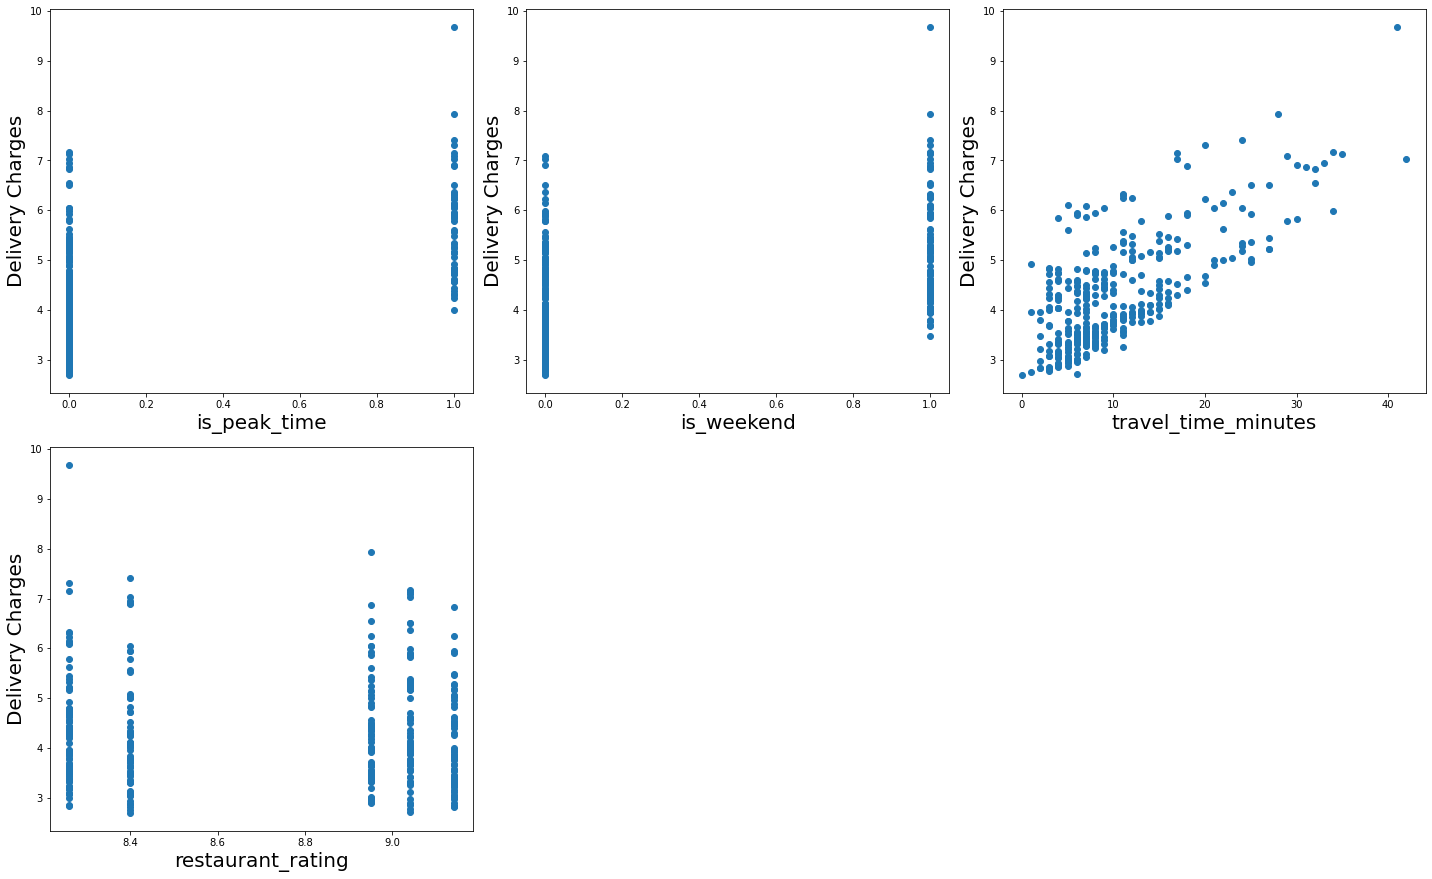

In [133]:
# plotting target variable with the features

plt.figure(figsize=(20,30), facecolor='white')
plotnumber = 1

for column in X:
    if plotnumber<=4 :
        ax = plt.subplot(5, 3, plotnumber)
        plt.scatter(X[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Delivery Charges',fontsize=20)
    plotnumber+=1
plt.tight_layout()

> The relation between `travel_time_minutes` and `delivery_charges` seems positive linear. Let us do it mathematically as well.

In [134]:
# splitting the dataset into 75% training and 25% testing
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=355)

In [135]:
# instantiating LinearRegression() and fitting the model

lm_for_impute = LinearRegression()
lm_for_impute.fit(x_train,y_train)

LinearRegression()

In [136]:
# printing the coefficients
lm_for_impute.coef_

array([ 1.46437487,  0.99211383,  0.10006773, -0.0635323 ])

In [137]:
# printing the intercept
lm_for_impute.intercept_

3.261579370892994

In [138]:
# models training and test scores

print('Train Score: ', lm_for_impute.score(x_train, y_train) )
print('Test Score: ', lm_for_impute.score(x_test,y_test) )

Train Score:  0.9674545007386138
Test Score:  0.9533434311874768


> These are pretty good accuracy.

In [139]:
# predictions of missing delivery charges column

print(np.round(lm_for_impute.predict(missing_na_df.drop(columns = ['delivery_charges'])) , 4))
missingdf_res_cust_nodes_df.loc[missing_na_df.index,('delivery_charges')] = np.round(lm_for_impute.predict(missing_na_df.drop(columns = ['delivery_charges'])) , 4)

[3.5284 6.0746 3.2813 3.5936 4.8859 4.9208 4.294  3.6879 4.382  3.3372
 4.7577 4.8382 6.3445 4.5926 5.6377 4.2293 3.4373 3.1282 4.5295 2.9932
 5.1523 3.5373 4.1797 3.2282 3.9938 4.3735 3.9818 3.6374 3.8817 3.2371
 3.5936 4.1854 5.1459 5.0825 4.2204 2.793  3.3372 4.329  3.3814 4.6926
 4.3204 3.1933 3.2813 3.5284 4.2204 3.9287 4.1289 3.9881 3.9881 3.0932
 3.9287 3.8287 6.253  3.1282 4.3856 3.5936 2.928  4.3798 3.2934 3.3283
 4.3884 3.7375 7.3948 4.1378 3.0932 4.9888 3.1933 4.1797 4.7801 5.5932
 3.1282 5.7022 3.2877 5.9304 2.8874 7.2818 7.7541 5.221  4.6292 4.7887
 3.7286 4.0288 3.8375 4.6295 3.3934 3.3283 4.2204 6.6854 3.1933 4.4291
 3.8881 5.8442 4.3204 5.0803 3.5815 4.3293 3.9881 3.5936 4.4821 5.2375
 4.4885 2.881  3.4878 5.0459 6.4468 3.5373 3.2813 4.0818 3.3934 6.2811
 4.1292 4.4291 3.8817 4.1378 3.6879 3.9881 3.8881 6.0939 3.2371 3.1371
 5.4301 3.3283 3.7937 3.3372 6.3468 3.5815 3.1812 6.0529 3.7816 4.4205
 4.6943 4.986  3.8817 3.9818 3.4935 5.7378 4.1883 3.2934 5.1299 4.0291
 3.993

In [140]:
print(missingdf_res_cust_nodes_df.shape)
missingdf_res_cust_nodes_df.isna().sum()

(500, 18)


order_id                         0
restaurant_id                    0
customer_id                      0
carrier_id                       0
customer_lat                     0
customer_lon                     0
date                             0
time                             0
is_peak_time                     0
is_weekend                       0
carrier_vehicle                  0
shopping_cart                    0
coupon_discount                  0
order_price                      0
shortest_distance_to_customer    0
travel_time_minutes              0
restaurant_rating                0
delivery_charges                 0
dtype: int64

> Our dataset is now clean without any missing values in any columns. Let's save the file now

In [141]:
# writing imputed csv
missingdf_res_cust_nodes_df.to_csv('31072100_missing_solution.csv', index=False)

---
---

# TASK 3: Detect and remove outlier rows

\
**Methodology**


We just have to consider `delivery_charges` column outliers. But as we have delivery_charges itself depend upon 4 features,so this problem becomes a multivariate outlier detection problem. There are several approaches to find out the multivariate outliers. Here we will be using the Linear Regression model approach as we already have trained model from our Task 2.

**We will be predicting the deliver_charges from the reliable model we build from the missing dataset in Task 2**. After getting the predicted values and delivery_charges present in the outlier dataset, we can convert the multivariate outlier problem to a univariate using the residuals

`Residuals = (True values) - (Predicted Values)`

By creating the box plot and using the upper and whisker approach, we can find the outliers from our dataset and get rid of them.





In [142]:
outlier_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   restaurant_id                  500 non-null    object 
 2   customer_id                    500 non-null    object 
 3   carrier_id                     500 non-null    object 
 4   customer_lat                   500 non-null    float64
 5   customer_lon                   500 non-null    float64
 6   date                           500 non-null    object 
 7   time                           500 non-null    object 
 8   is_peak_time                   500 non-null    int64  
 9   is_weekend                     500 non-null    int64  
 10  carrier_vehicle                500 non-null    object 
 11  shopping_cart                  500 non-null    object 
 12  coupon_discount                500 non-null    int

In [143]:
outlier_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges
0,ORD027210,REST1046,CUST03492,COUR3492,-37.813359,144.938660,2020-07-12,03:53:24,0,1,Bike,"[('fried rice', 2), ('fish fingers', 1), ('bee...",0,51.540,1749,9,4.5473
1,ORD184211,REST1034,CUST05128,COUR2690,-37.821935,144.955442,2020-01-04,23:28:21,0,1,Car,"[('butter chicken', 1), ('manchurian', 1)]",0,34.980,2526,6,3.9081
2,ORD003542,REST1046,CUST10956,COUR0632,-37.800126,144.951505,2020-02-05,19:11:12,1,0,Car,"[('chicken curry', 3), ('fried rice', 1)]",10,27.000,3872,9,4.7367
3,ORD345584,REST1046,CUST10007,COUR1872,-37.804138,145.002140,2020-03-02,14:10:32,0,0,Bike,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,115.340,7081,35,6.2313
4,ORD077387,REST1046,CUST12722,COUR3943,-37.814973,144.927388,2020-12-23,14:54:03,0,0,Car,"[('murgh ghee roast', 2), ('fried rice', 1), (...",10,30.762,2070,5,2.9509


In [144]:
outlier_df['restaurant_id'].unique()

array(['REST1046', 'REST1034', 'REST1455', 'REST0348', 'REST0931'],
      dtype=object)

In [145]:
inhand_restaurants

array(['REST1455', 'REST0348', 'REST1046', 'REST0931', 'REST1034'],
      dtype=object)

---
## 3.1 Adding the ratings column



In [146]:
required_outlier_df = pd.merge(outlier_df, inhand_res_info[['restaurant_id', 'calculated_rating']], how='left', on='restaurant_id')
required_outlier_df['restaurant_rating'] = required_outlier_df['calculated_rating']
required_outlier_df.drop(columns=['calculated_rating'], inplace=True)
required_outlier_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges,restaurant_rating
0,ORD027210,REST1046,CUST03492,COUR3492,-37.813359,144.938660,2020-07-12,03:53:24,0,1,Bike,"[('fried rice', 2), ('fish fingers', 1), ('bee...",0,51.540,1749,9,4.5473,9.04
1,ORD184211,REST1034,CUST05128,COUR2690,-37.821935,144.955442,2020-01-04,23:28:21,0,1,Car,"[('butter chicken', 1), ('manchurian', 1)]",0,34.980,2526,6,3.9081,8.40
2,ORD003542,REST1046,CUST10956,COUR0632,-37.800126,144.951505,2020-02-05,19:11:12,1,0,Car,"[('chicken curry', 3), ('fried rice', 1)]",10,27.000,3872,9,4.7367,9.04
3,ORD345584,REST1046,CUST10007,COUR1872,-37.804138,145.002140,2020-03-02,14:10:32,0,0,Bike,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,115.340,7081,35,6.2313,9.04
4,ORD077387,REST1046,CUST12722,COUR3943,-37.814973,144.927388,2020-12-23,14:54:03,0,0,Car,"[('murgh ghee roast', 2), ('fried rice', 1), (...",10,30.762,2070,5,2.9509,9.04


---
## 3.2 Predicting, Calculating Residual and Removing Outliers

In [147]:
# predicting and creating new column with the predicting values
required_outlier_df['pred_delivery_charges'] = np.round( lm_for_impute.predict(required_outlier_df[['is_peak_time', 'is_weekend', 'travel_time_minutes', 'restaurant_rating']]) , 4)
required_outlier_df.head()

,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges,restaurant_rating,pred_delivery_charges
0,ORD027210,REST1046,CUST03492,COUR3492,-37.813359,144.938660,2020-07-12,03:53:24,0,1,Bike,"[('fried rice', 2), ('fish fingers', 1), ('bee...",0,51.540,1749,9,4.5473,9.04,4.5800
1,ORD184211,REST1034,CUST05128,COUR2690,-37.821935,144.955442,2020-01-04,23:28:21,0,1,Car,"[('butter chicken', 1), ('manchurian', 1)]",0,34.980,2526,6,3.9081,8.40,4.3204
2,ORD003542,REST1046,CUST10956,COUR0632,-37.800126,144.951505,2020-02-05,19:11:12,1,0,Car,"[('chicken curry', 3), ('fried rice', 1)]",10,27.000,3872,9,4.7367,9.04,5.0522
3,ORD345584,REST1046,CUST10007,COUR1872,-37.804138,145.002140,2020-03-02,14:10:32,0,0,Bike,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,115.340,7081,35,6.2313,9.04,6.1896
4,ORD077387,REST1046,CUST12722,COUR3943,-37.814973,144.927388,2020-12-23,14:54:03,0,0,Car,"[('murgh ghee roast', 2), ('fried rice', 1), (...",10,30.762,2070,5,2.9509,9.04,3.1876


In [148]:
# required_outlier_df.boxplot(column=['delivery_charges', 'pred_delivery_charges'])

In [149]:
# calculating residuals
required_outlier_df['residual'] = (required_outlier_df['delivery_charges'] - required_outlier_df['pred_delivery_charges'])
required_outlier_df.head()


,order_id,restaurant_id,customer_id,carrier_id,customer_lat,customer_lon,date,time,is_peak_time,is_weekend,carrier_vehicle,shopping_cart,coupon_discount,order_price,shortest_distance_to_customer,travel_time_minutes,delivery_charges,restaurant_rating,pred_delivery_charges,residual
0,ORD027210,REST1046,CUST03492,COUR3492,-37.813359,144.938660,2020-07-12,03:53:24,0,1,Bike,"[('fried rice', 2), ('fish fingers', 1), ('bee...",0,51.540,1749,9,4.5473,9.04,4.5800,-0.0327
1,ORD184211,REST1034,CUST05128,COUR2690,-37.821935,144.955442,2020-01-04,23:28:21,0,1,Car,"[('butter chicken', 1), ('manchurian', 1)]",0,34.980,2526,6,3.9081,8.40,4.3204,-0.4123
2,ORD003542,REST1046,CUST10956,COUR0632,-37.800126,144.951505,2020-02-05,19:11:12,1,0,Car,"[('chicken curry', 3), ('fried rice', 1)]",10,27.000,3872,9,4.7367,9.04,5.0522,-0.3155
3,ORD345584,REST1046,CUST10007,COUR1872,-37.804138,145.002140,2020-03-02,14:10:32,0,0,Bike,"[('murgh ghee roast', 2), ('chicken curry', 3)...",0,115.340,7081,35,6.2313,9.04,6.1896,0.0417
4,ORD077387,REST1046,CUST12722,COUR3943,-37.814973,144.927388,2020-12-23,14:54:03,0,0,Car,"[('murgh ghee roast', 2), ('fried rice', 1), (...",10,30.762,2070,5,2.9509,9.04,3.1876,-0.2367


<AxesSubplot:>

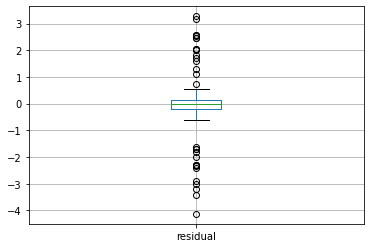

In [150]:
# boxplot od residuals
required_outlier_df.boxplot(column='residual')

> We have quite a few outliers. Let's fix them now.

In [151]:
required_outlier_df['residual'].describe()

count    500.000000
mean      -0.033830
std        0.629198
min       -4.133250
25%       -0.191675
50%       -0.023250
75%        0.122300
max        3.276650
Name: residual, dtype: float64

In [152]:
# Calculating values associated with the Tukey Boxplot

Q1 = required_outlier_df['residual'].describe()['25%']
Q3 = required_outlier_df['residual'].describe()['75%']

# Inter-Quartile Range
IQR = Q3 - Q1

# lower wisker
lower_wisker = Q1 - (1.5*IQR)

# upper wisker
upper_wisker = Q3 + (1.5*IQR)

print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)
print('lower_wisker: ', lower_wisker)
print('upper_wisker: ', upper_wisker)

Q1:  -0.19167500000000015
Q3:  0.12229999999999963
IQR:  0.3139749999999998
lower_wisker:  -0.6626374999999998
upper_wisker:  0.5932624999999994


In [153]:
lower_outliers_index = required_outlier_df[ required_outlier_df['residual'] < round(lower_wisker,4) ].index
upper_outliers_index = required_outlier_df[ required_outlier_df['residual'] > round(upper_wisker,4) ].index

In [154]:
lower_outliers_index

Int64Index([20, 25, 43, 68, 109, 139, 142, 178, 208, 248, 277, 309, 326, 386, 481], dtype='int64')

In [155]:
upper_outliers_index

Int64Index([5, 15, 23, 39, 51, 66, 72, 203, 233, 240, 271, 306, 317, 368, 475, 491], dtype='int64')

> There are **31 outliers** in deliver_charges attribute. Let's remove these rows from their index

In [156]:
# droping the outlier rows

required_outlier_df.drop(index=lower_outliers_index, inplace=True)
required_outlier_df.drop(index=upper_outliers_index, inplace=True)

required_outlier_df.shape

(469, 20)

In [157]:
# removing the extra columns

required_outlier_df.drop(columns=['restaurant_rating', 'pred_delivery_charges', 'residual'], inplace=True)
required_outlier_df.shape

(469, 17)

In [158]:
# writing imputed csv
required_outlier_df.to_csv('31072100_outlier_solution.csv', index=False)

# REFERENCES



* DSM. Answer on Stackoverflow. Retrieved from https://stackoverflow.com/questions/25792619/what-is-correct-syntax-to-swap-column-values-for-selected-rows-in-a-pandas-data

* Kite. How to split a pandas DataFrame into multiple DataFrames by column value in Python. Retreived from https://www.kite.com/python/answers/how-to-split-a-pandas-dataframe-into-multiple-dataframes-by-column-value-in-python

* percusse. Answer on Stackoverfloe. Retrieved from https://stackoverflow.com/questions/49357417/why-is-numpy-linalg-pinv-preferred-over-numpy-linalg-inv-for-creating-invers

* Wikipedia. Moore-Penrose Inverse. Retrieved from https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse